---
title: "Understanding log-score and LPPD"

---


It's unclear to me how this can be used to say whether a model is better or not. One way to think of it is that this R^2 for the training set. The book uses model m_7.1 as the example.

Assisted by [this video](https://youtu.be/6kQYewSWJDg?t=220), another explanation of WAIC.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.interpolate import griddata

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(vec):
    return (vec - np.mean(vec)) / np.std(vec)

<IPython.core.display.Javascript object>

# Setting up the problem

In [4]:
# code modified from the repo

df_brains = pd.DataFrame(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

<IPython.core.display.Javascript object>

In [5]:
# Standardized
df_brains["mass_std"] = standardize(df_brains["mass"])  

# Standardize variables (min-max scale)
df_brains["brain_std"] = (
    df_brains["brain"] / df_brains["brain"].max()
)  # min-max scaling (min at 0)


<IPython.core.display.Javascript object>

In [6]:
df_brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'standardized values')

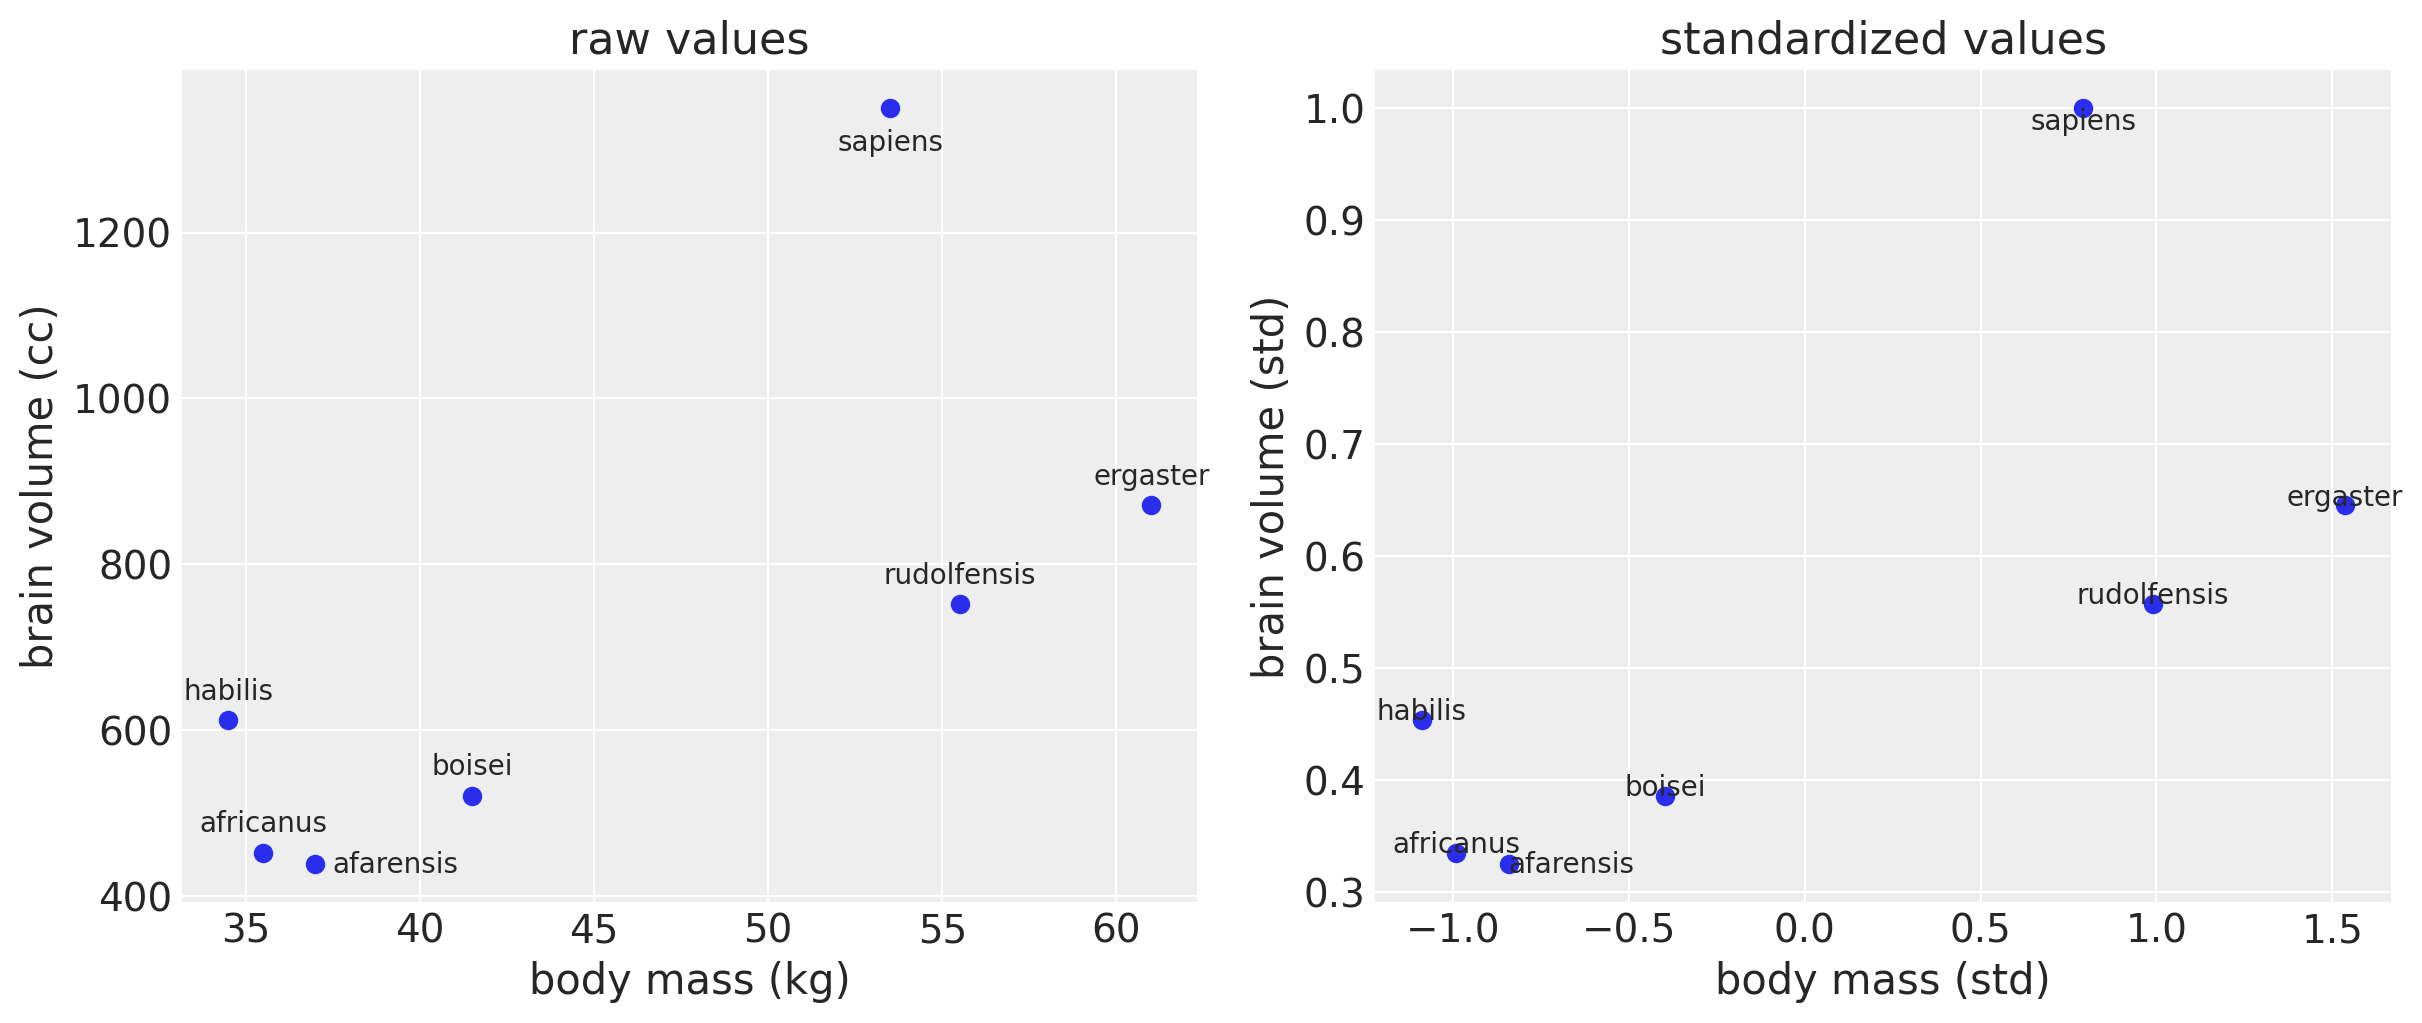

<IPython.core.display.Javascript object>

In [7]:
# Figure 7.2, modified from repo

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(df_brains["mass"], df_brains["brain"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax1.text(r["mass"] + 0.5, r["brain"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax1.text(r["mass"], r["brain"] - 25, r["species"], ha="center", va="top")
    else:
        ax1.text(r["mass"], r["brain"] + 25, r["species"], ha="center")

ax1.set_xlabel("body mass (kg)")
ax1.set_ylabel("brain volume (cc)")
ax1.set_title("raw values")

ax2.scatter(df_brains["mass_std"], df_brains["brain_std"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center", va="top")
    else:
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center")

ax2.set_xlabel("body mass (std)")
ax2.set_ylabel("brain volume (std)")
ax2.set_title("standardized values")

# Calculating $R^2$

## $R^2$ the OLS way

The repo uses statsmodels OLS. Ultimately, I'd like to learn with PyMC, but let's start with OLS so that we have something to compare to.

In [8]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=df_brains).fit()
m_7_1.summary()

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Sat, 29 May 2021   Prob (F-statistic):             0.0798
Time:                        07:37:08   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1547      0.071      2.192      0.080      -0.027       0.336
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [9]:
def R2_is_bad_ols(model):
    return 1 - model.resid.var() / df_brains['brain_std'].var()


<IPython.core.display.Javascript object>

In [10]:
print("R2 with OLS: {0:0.3f}".format(R2_is_bad_ols(m_7_1)))

R2 with OLS: 0.490


<IPython.core.display.Javascript object>

In [11]:
m_7_1.resid

0   -0.073970
1   -0.040612
2    0.093232
3   -0.081451
4   -0.124891
5   -0.121031
6    0.348722
dtype: float64

<IPython.core.display.Javascript object>

In [12]:
print("Residuals for each observation: ")
[
    print(df_brains.loc[i, "species"] + "  {0:0.3f}".format(val))
    for i, val in enumerate(m_7_1.resid.tolist())
]

Residuals for each observation: 
afarensis  -0.074
africanus  -0.041
habilis  0.093
boisei  -0.081
rudolfensis  -0.125
ergaster  -0.121
sapiens  0.349


[None, None, None, None, None, None, None]

<IPython.core.display.Javascript object>

Shows OLS residual is returning the difference to the mean line. Let's get this from the PyMC posterior.

## $R^2$ the PyMC way

Create the model. Here are the variables.

$b_i$ ~ $\text{Normal}(\mu_i, \sigma)$
<br>
$\mu_i$ = $\alpha + \beta m_i$
<br>
$\alpha$ ~ $\text{Normal}(0.5, 1)$
<br>
$\beta$ ~ $\text{Normal}(0, 10)$
<br>
$\sigma$ ~ $\text{Log-Normal}(0, 1)$

In [13]:
with pm.Model() as m7_1:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=10)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = a + b * df_brains["mass_std"]
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    sample = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

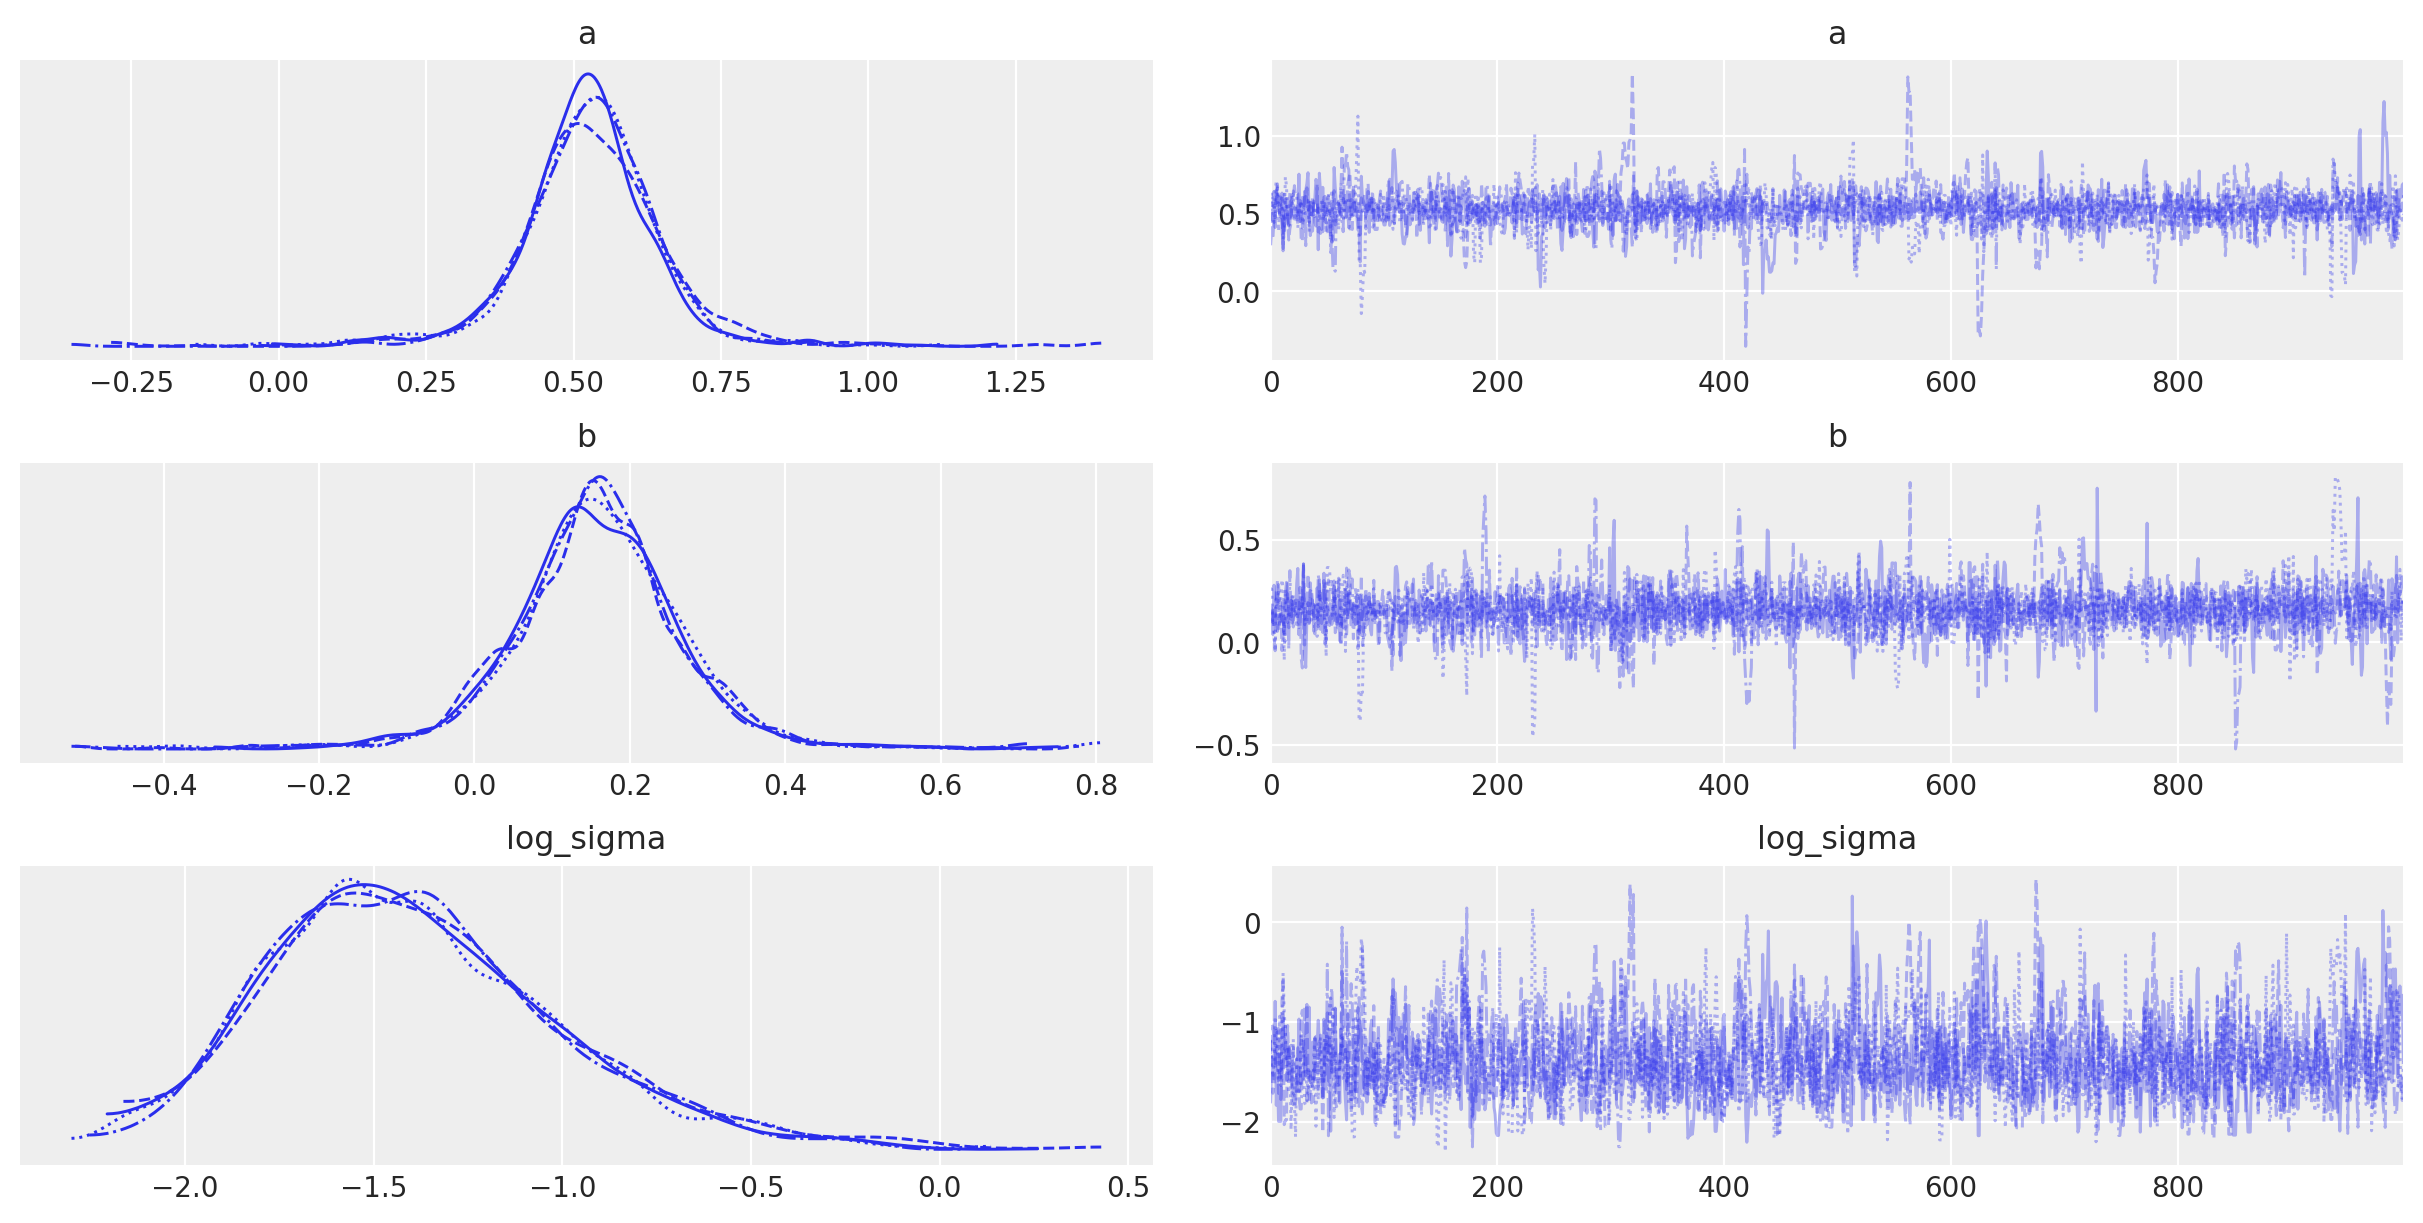

<IPython.core.display.Javascript object>

In [15]:
with m7_1:
    az.plot_trace(sample)


In [16]:
az.summary(sample, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.526,0.121,0.372,0.708
b,0.158,0.114,0.002,0.329
log_sigma,-1.385,0.397,-2.004,-0.789


<IPython.core.display.Javascript object>

In [17]:
sample.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    a          (chain, draw) float64 0.4999 0.4932 0.4528 ... 0.5676 0.4917
    b          (chain, draw) float64 0.1145 0.08545 0.03828 ... 0.1979 0.09667
    log_sigma  (chain, draw) float64 -1.807 -1.342 -1.549 ... -1.767 -1.584
Attributes:
    created_at:                 2021-05-29T14:37:37.813942
    arviz_version:              0.11.1
    inference_library:          pymc3
    inference_library_version:  3.11.0
    sampling_time:              12.189349174499512
    tuning_steps:               1000

<IPython.core.display.Javascript object>

Get the mean value at each body mass data point. Since we standardized the values, we use the transformed values first. While we are only using the mean, let's go ahead and use the full posterior values as a re-iteration of a prior lesson. I'll put things in a dataframe since it's more intuitive for me to work with it.

In [18]:
df_sample = sample.to_dataframe()
df_sample.head()

,chain,draw,"(posterior, a)","(posterior, b)","(posterior, log_sigma)","(log_likelihood, brain_std[0], 0)","(log_likelihood, brain_std[1], 1)","(log_likelihood, brain_std[2], 2)","(log_likelihood, brain_std[3], 3)","(log_likelihood, brain_std[4], 4)",...,"(sample_stats, tree_size)","(sample_stats, energy_error)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, perf_counter_start)","(sample_stats, depth)","(sample_stats, energy)","(sample_stats, perf_counter_diff)","(sample_stats, max_energy_error)","(sample_stats, step_size_bar)"
0,0,0,0.499901,0.114539,-1.807259,0.772375,0.838817,0.774701,0.800959,0.829440,...,3.0,-0.275422,0.886504,False,9.866557,2,5.387845,0.000454,0.348327,0.627796
1,0,1,0.493239,0.085452,-1.341995,0.354379,0.383196,0.402336,0.383549,0.419876,...,3.0,0.087133,0.916555,False,9.867119,2,5.949211,0.000424,-0.592547,0.627796
2,0,2,0.452766,0.038279,-1.548945,0.527734,0.559059,0.610213,0.600432,0.581238,...,3.0,0.102604,0.923871,False,9.867650,2,5.945732,0.000445,0.169593,0.627796
3,0,3,0.642973,0.278632,-1.571996,0.571333,0.641051,0.502480,0.403613,-0.866137,...,7.0,0.564181,0.778417,False,9.868204,3,7.183075,0.000833,0.564181,0.627796
4,0,4,0.410273,0.140215,-0.794062,-0.127417,-0.134721,-0.218728,-0.127260,-0.125029,...,7.0,0.288928,0.838344,False,9.869146,3,8.669764,0.000825,0.623380,0.627796


<IPython.core.display.Javascript object>

(It looks like there's a lot of useful information here but I will ignore everything except the `posterior` columns right now.)

## Pymc sigma

(array([6.590e+02, 1.402e+03, 9.430e+02, 4.660e+02, 2.350e+02, 1.060e+02,
        7.300e+01, 3.600e+01, 2.200e+01, 2.100e+01, 1.400e+01, 8.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.10000174, 0.17189299, 0.24378425, 0.3156755 , 0.38756675,
        0.45945801, 0.53134926, 0.60324051, 0.67513177, 0.74702302,
        0.81891428, 0.89080553, 0.96269678, 1.03458804, 1.10647929,
        1.17837054, 1.2502618 , 1.32215305, 1.39404431, 1.46593556,
        1.53782681]),
 <BarContainer object of 20 artists>)

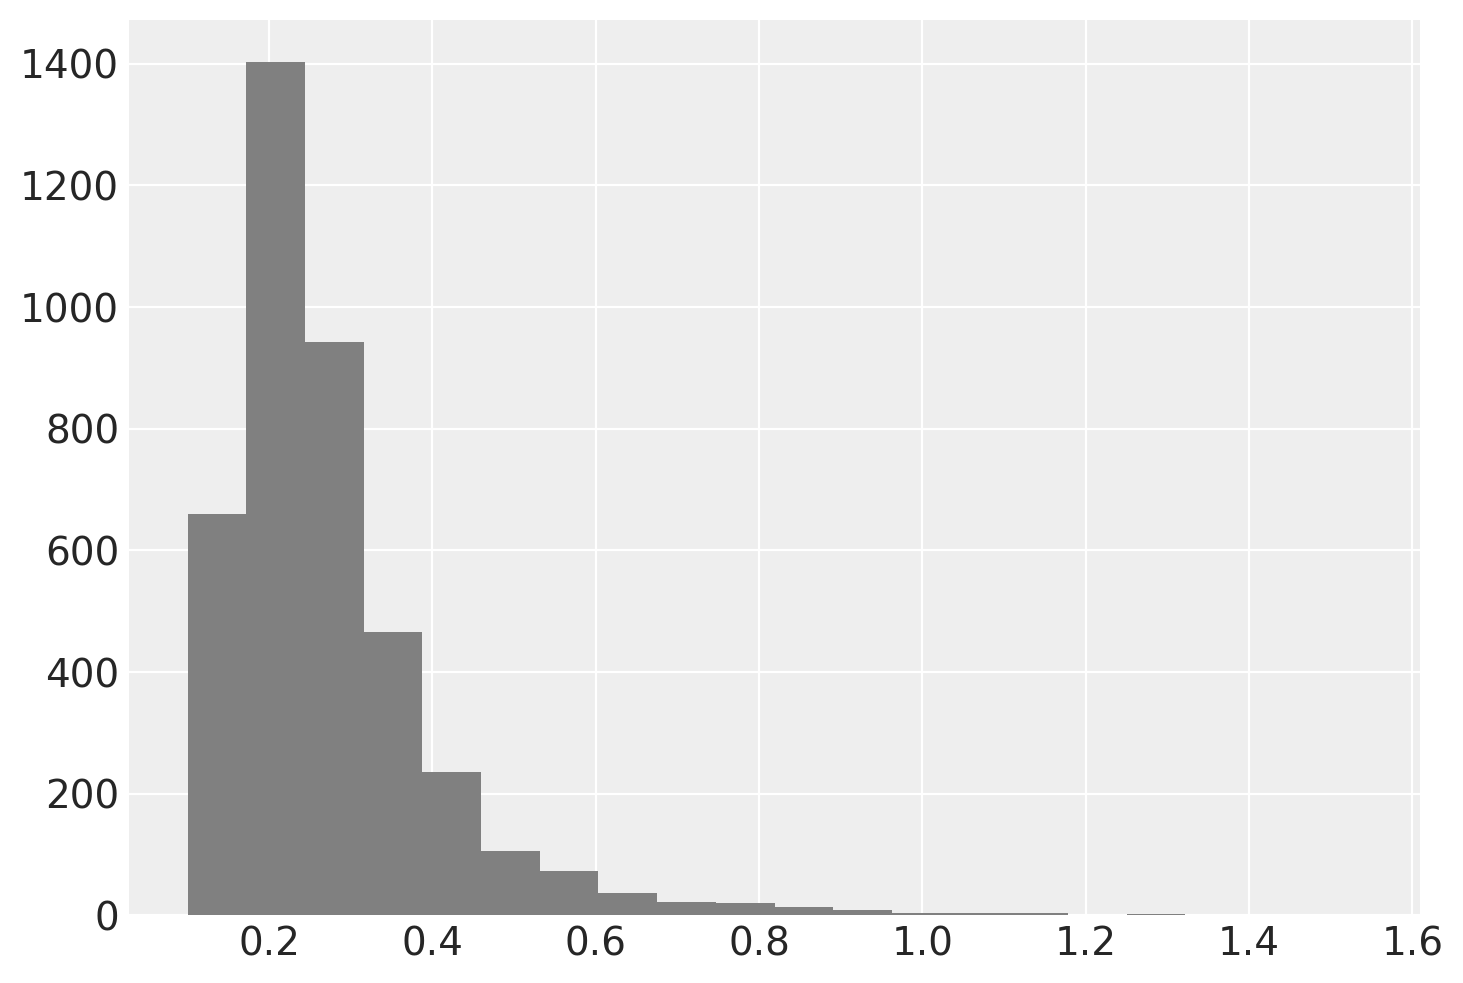

<IPython.core.display.Javascript object>

In [19]:
plt.hist(np.exp(df_sample[("posterior", "log_sigma")]), bins=20, color="gray")

In [20]:
np.mean(np.exp(df_sample[("posterior", "log_sigma")]))

0.2732133356191027

<IPython.core.display.Javascript object>

### Comparison with numpyro sigma

Text(0.5, 1.0, 'Numpyro sigma')

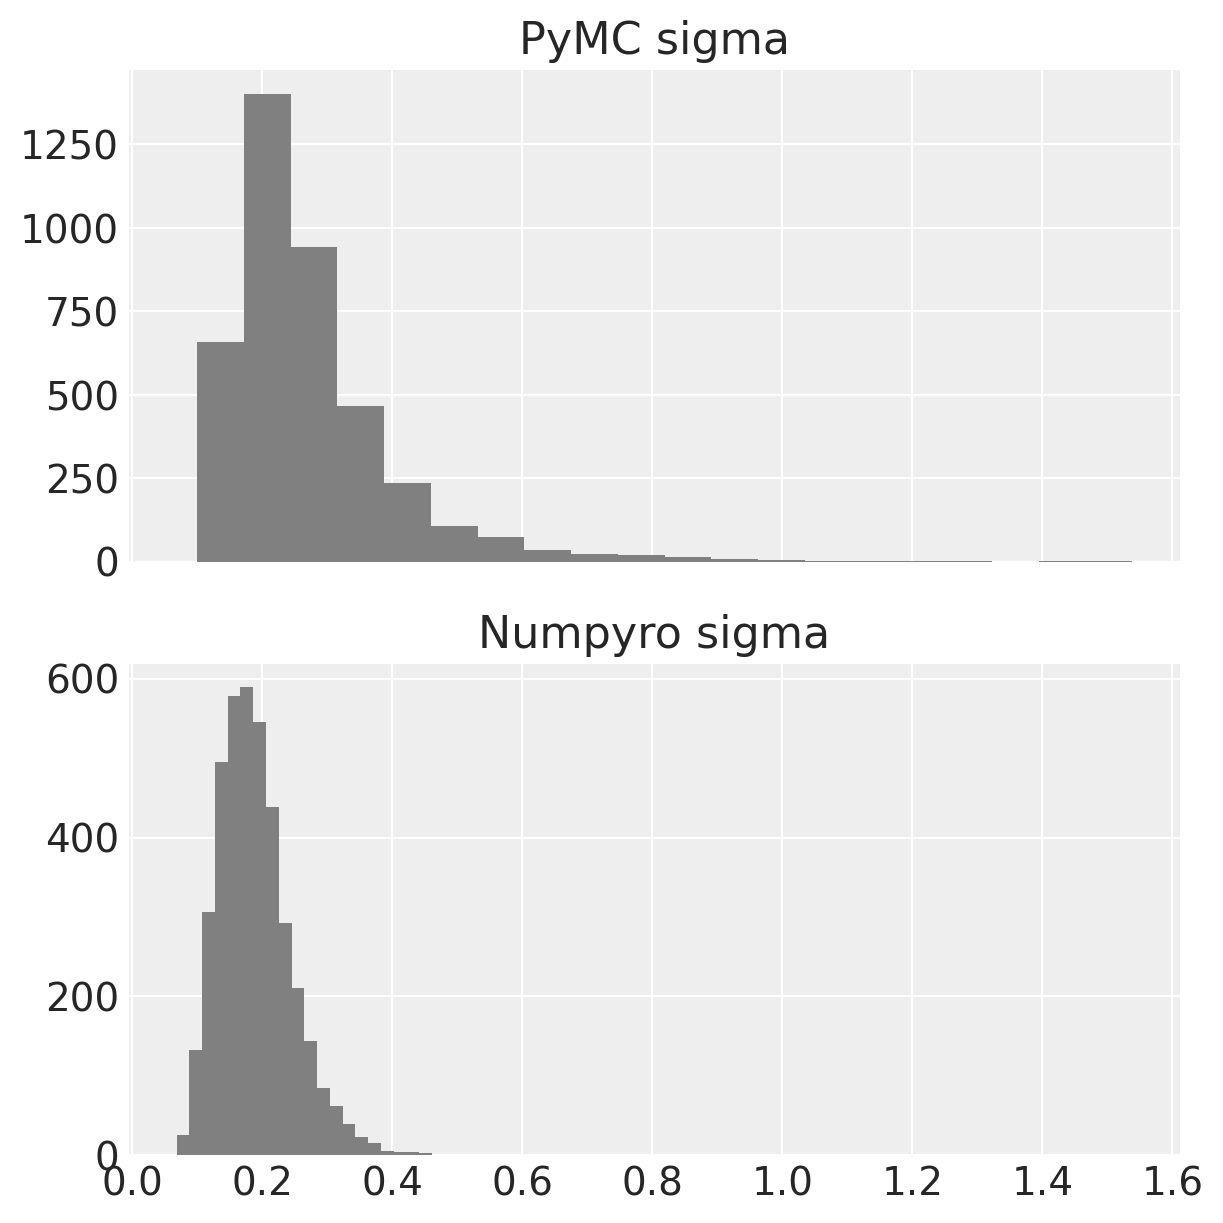

<IPython.core.display.Javascript object>

In [37]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

ax1.hist(np.exp(df_sample[("posterior", "log_sigma")]), bins=20, color="gray")
ax1.set_title("PyMC sigma")

ax2.hist(np.exp(post["log_sigma"]), bins=20, color="gray")
ax2.set_title("Numpyro sigma")

In [36]:
print(
    "PyMC sigma mean: {0:0.3f}".format(
        np.mean(np.exp(df_sample[("posterior", "log_sigma")]))
    )
)

print(
    "Numpyro sigma mean: {0:0.3f}".format(
        np.mean(numpyro_sigmas))
    )


PyMC sigma mean: 0.273
Numpyro sigma mean: 0.189


<IPython.core.display.Javascript object>

In [33]:
# This is generating a matrix where the predicted mu values will be kept
# Each weight value will be its own row
mu_pred = np.zeros((len(df_brains["mass_std"]), len(df_sample)))

# Fill out the matrix in this loop, note the tuple syntax to reference the posterior values
for i, m in enumerate(df_brains["mass_std"]):
    mu_pred[i] = df_sample[("posterior", "a")] + df_sample[("posterior", "b")] * m

<IPython.core.display.Javascript object>

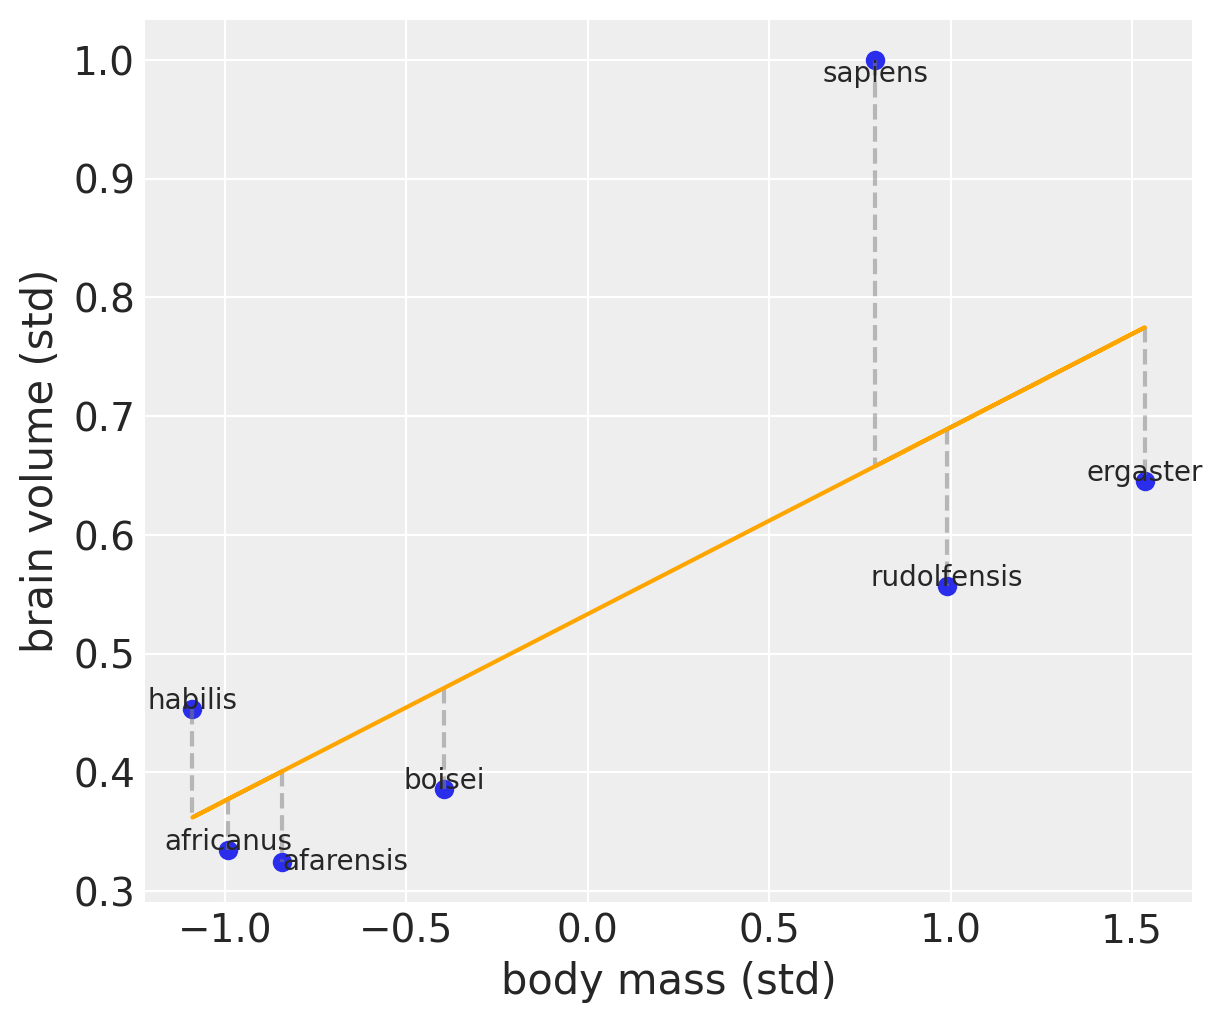

<IPython.core.display.Javascript object>

In [36]:
f, (ax2) = plt.subplots(1, 1, figsize=(6, 5))

ax2.scatter(df_brains["mass_std"], df_brains["brain_std"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center", va="top")
    else:
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center")

ax2.set_xlabel("body mass (std)")
ax2.set_ylabel("brain volume (std)")

# Plotting the overall mean line
ax2.plot(
    df_brains["mass_std"],
    df_sample[('posterior', 'a')].mean() + df_sample[('posterior', 'b')].mean() * df_brains["mass_std"],
    label="posterior mean line",
    color="orange",
)

# Plot residuals
res = df_brains["brain_std"] - (
    df_sample[("posterior", "a")].mean()
    + df_sample[("posterior", "b")].mean() * df_brains["mass_std"]
)

for i, res_val in enumerate(res):
    if res_val > 0:
        ymin = df_brains.loc[i, "brain_std"]
        ymax = df_brains.loc[i, "brain_std"] - res_val
    else:
        ymin = df_brains.loc[i, "brain_std"] - res_val
        ymax = df_brains.loc[i, "brain_std"]
    ax2.vlines(df_brains.loc[i, "mass_std"], ymin=ymin, ymax=ymax, color='gray', linestyle='dashed', alpha=0.5)
        #ax2.vlines(df_brains.loc[i, "mass_std"], ymin=0, ymax=0.5)


We can quickly do a sanity check and see that our method for getting the residuals using this roundabout PyMC approach matches what we found with OLS.

In [96]:
pd.DataFrame({"species": df_brains["species"], "OLS_res": m_7_1.resid, "PyMC_res": res})

,species,OLS_res,PyMC_res
0,afarensis,-0.073970,-0.076501
1,africanus,-0.040612,-0.042774
2,habilis,0.093232,0.091316
3,boisei,-0.081451,-0.085090
4,rudolfensis,-0.124891,-0.131975
5,ergaster,-0.121031,-0.129469
6,sapiens,0.348722,0.342130


<IPython.core.display.Javascript object>

Results are similar for both.

# Posterior predictions of brain volume

In [210]:
df_brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


<IPython.core.display.Javascript object>

In [214]:
# compute the hpdi for a range of standardized body mass

cred_intervals = np.array(
    [
        az.hdi(
            np.array(df_sample[("posterior", "a")])
            + np.array(df_sample[("posterior", "b")]) * x
        )
        for x in np.arange(
            -1.1, 1.8, 0.1
        )  # This is inputting a range of std body mass values
    ]
)

# Take a look at credibility intervals
cred_intervals[0:5]

array([[0.11112774, 0.60777672],
       [0.13971798, 0.61318222],
       [0.16399126, 0.61689898],
       [0.19148588, 0.62069271],
       [0.21644001, 0.62422998]])

<IPython.core.display.Javascript object>

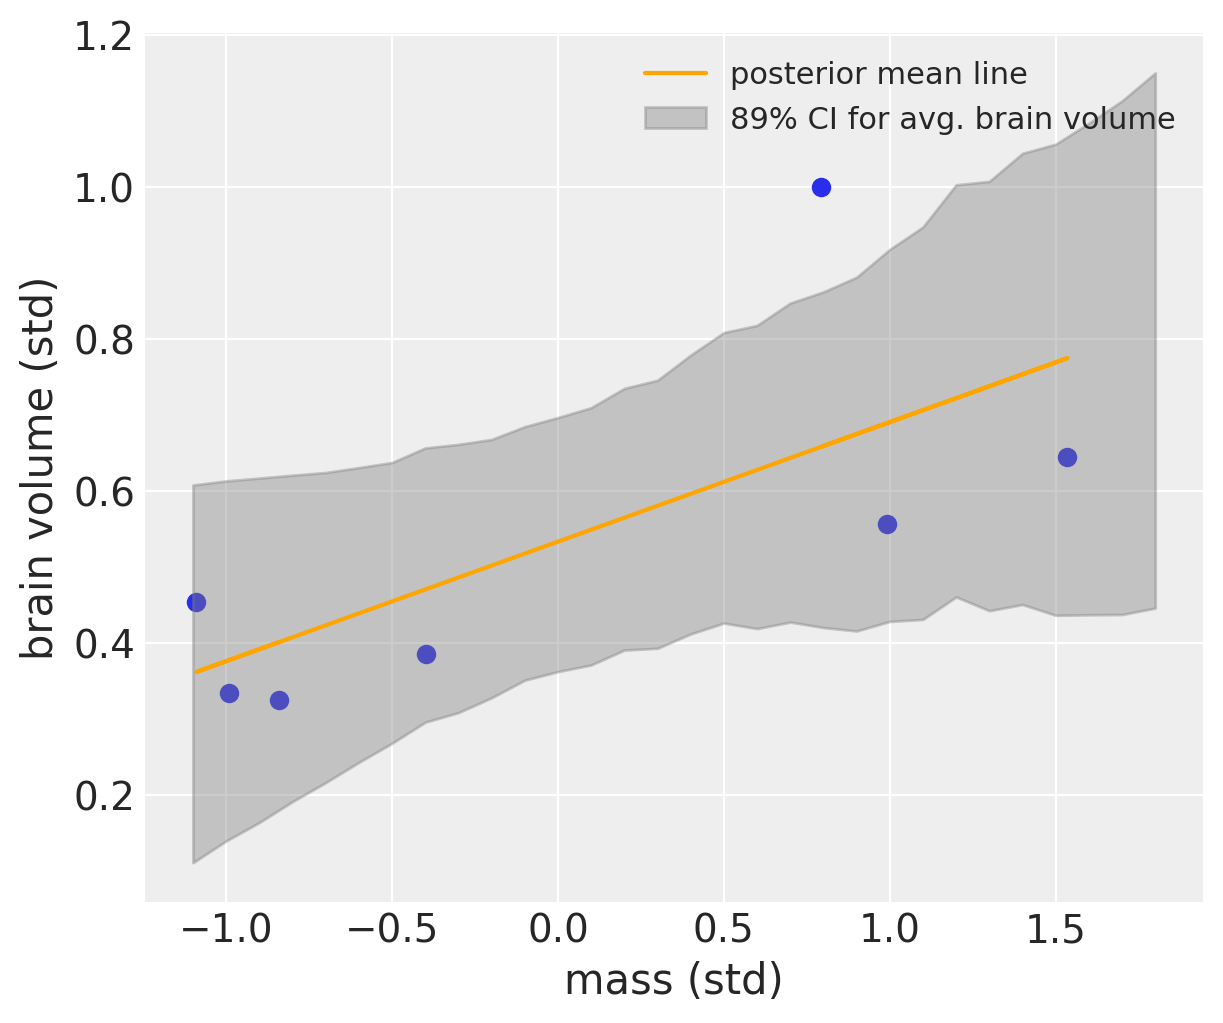

<IPython.core.display.Javascript object>

In [227]:
f, ax1 = plt.subplots(1, 1, figsize=(6, 5))


# ax1 plot --------------------------------------------
# Plotting the data as a scatter plot
ax1.scatter(df_brains["mass_std"], df_brains["brain_std"], alpha=1)

ax1.fill_between(
    np.arange(-1.1, 1.8, 0.1),
    cred_intervals[:, 0],
    cred_intervals[:, 1],
    alpha=0.4,
    color="gray",
    label="89% CI for avg. brain volume",
)

# Plotting the overall mean line
ax1.plot(
    df_brains["mass_std"],
    df_sample[("posterior", "a")].mean()
    + df_sample[("posterior", "b")].mean() * df_brains["mass_std"],
    label="posterior mean line",
    color="orange",
)

ax1.set_xlabel("mass (std)")
ax1.set_ylabel("brain volume (std)")
ax1.legend(fontsize=11)

In [224]:
# Input a range of standardized body masses
mass_seq = np.arange(-1.1, 1.8, 0.1)

# This is generating a matrix where the predicted brain_volume values will be kept
# Each standardized body mass value will be its own row
b_pred = np.zeros((len(mass_seq), len(df_sample)))

# Fill out the matrix in this loop
for i, mass_i in enumerate(mass_seq):
    b_pred[i] = stats.norm.rvs(
        loc=df_sample[("posterior", "a")] + df_sample[("posterior", "b")] * mass_i,
        scale=np.exp(df_sample[("posterior", "log_sigma")]),
    )

# Output the matrix in a dataframe for viewing
df_b_pred = pd.DataFrame(b_pred, index=mass_seq)
df_b_pred.index.name = "mass_std"
df_b_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
mass_std,,,,,,,,,,,,,,,,,,,,,
-1.1,0.676187,0.290051,0.362018,0.277553,0.796084,0.672703,0.774921,0.610825,0.651393,0.544749,...,-0.125547,-0.401474,0.755756,0.775113,-0.012650,0.008156,0.106850,0.351430,0.845430,0.614697
-1.0,-0.041104,0.243708,0.548456,0.416344,-0.013360,0.252797,0.686340,0.297991,0.750898,0.593206,...,0.236927,0.322123,0.850673,0.440864,0.232453,0.693089,0.356506,0.676502,0.451937,0.193947
-0.9,-0.400673,0.613989,0.039795,-0.062217,0.595577,0.533648,0.527125,0.327406,0.728397,0.767278,...,0.096944,0.504864,0.845617,0.716018,-0.307980,0.495794,0.521800,0.287662,0.264909,0.626452
-0.8,-0.006333,0.249231,0.520449,-0.155230,1.341163,0.780821,0.966771,0.290100,0.072581,0.458489,...,0.338007,0.250964,0.494340,0.429963,0.397961,0.407351,-0.042101,0.321505,0.307512,0.443332
-0.7,0.006118,-0.394139,0.345840,0.331987,0.795812,0.121102,0.557793,0.744556,0.228089,0.787171,...,0.155134,0.307066,0.994788,0.332699,0.226518,0.657050,0.567040,0.726736,0.425042,0.426385


<IPython.core.display.Javascript object>

(-1.0, 2.0)

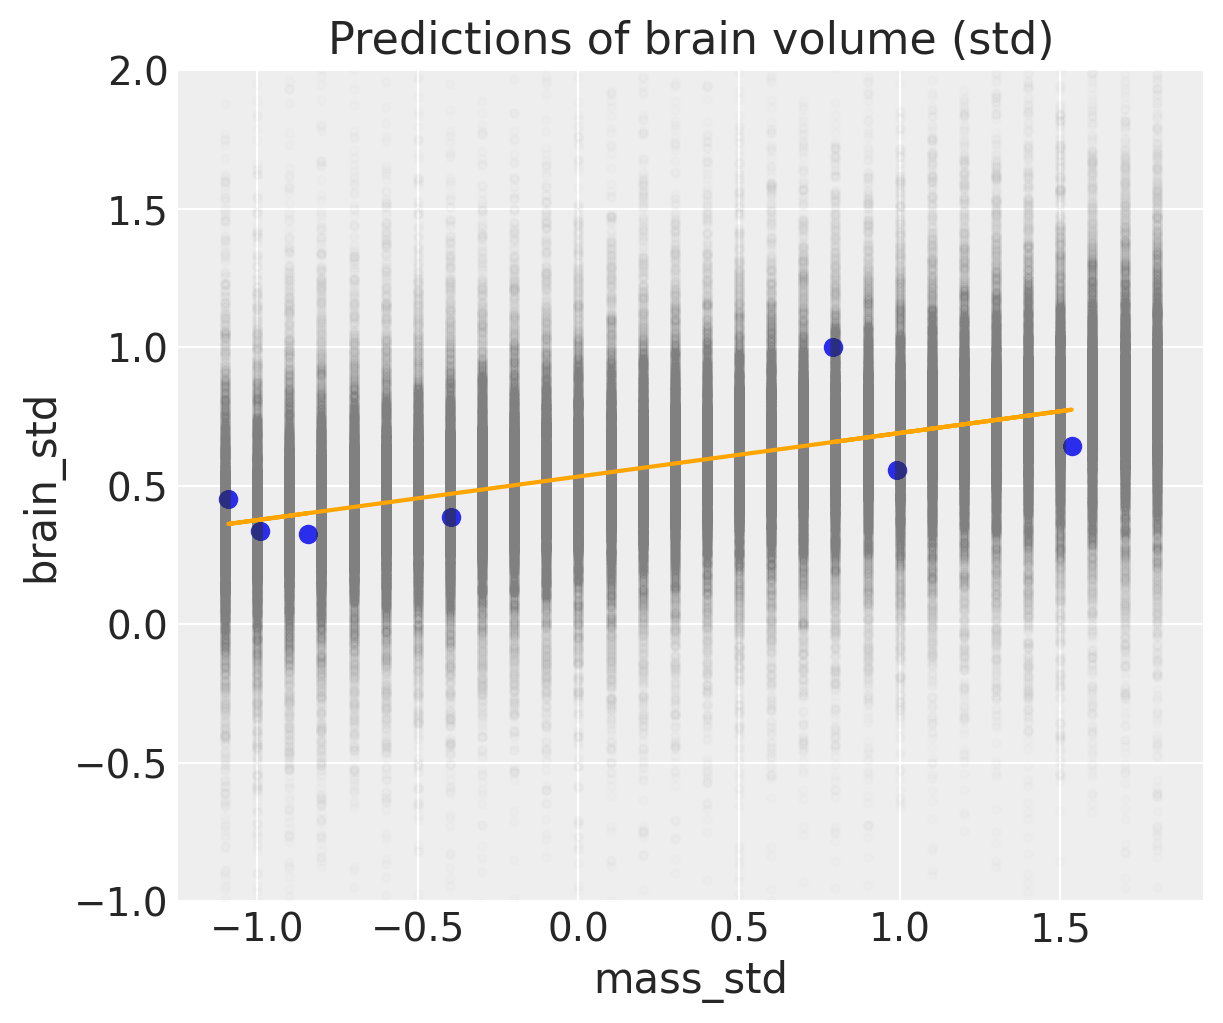

<IPython.core.display.Javascript object>

In [228]:
f, ax1 = plt.subplots(figsize=(6, 5))

# Plotting the data as a scatter plot
ax1.plot(mass_seq, b_pred, "C0.", color="gray", alpha=0.01)
ax1.scatter(df_brains["mass_std"], df_brains["brain_std"], alpha=1)
ax1.set_xlabel("mass_std")
ax1.set_ylabel("brain_std")
ax1.set_title("Predictions of brain volume (std)")

# Plotting the overall mean line
ax1.plot(
    df_brains["mass_std"],
    df_sample[("posterior", "a")].mean()
    + df_sample[("posterior", "b")].mean() * df_brains["mass_std"],
    label="posterior mean line",
    color="orange",
)

ax1.set_ylim([-1, 2])

# Calculation of lppd

We have this roundabout way for getting $R^2$ values but how does that relate to getting log-score and LPPD? The book doesn't show the code for log score, but it looks like they use the mean from the posterior distribution. It does show the LPPD code however. I had some confusion about the Python repo so I referred to McElreath's R code for a more direct translation.

```
## R code 7.14
set.seed(1)
logprob <- sim( m7.1 , ll=TRUE , n=1e4 )
n <- ncol(logprob)
ns <- nrow(logprob)
f <- function( i ) log_sum_exp( logprob[,i] ) - log(ns)
( lppd <- sapply( 1:n , f ) )
```

In [ ]:
from scipy.special import logsumexp

In [31]:
sample

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

In [32]:
df_sample

,chain,draw,"(posterior, a)","(posterior, b)","(posterior, log_sigma)","(log_likelihood, brain_std[0], 0)","(log_likelihood, brain_std[1], 1)","(log_likelihood, brain_std[2], 2)","(log_likelihood, brain_std[3], 3)","(log_likelihood, brain_std[4], 4)",...,"(sample_stats, tree_size)","(sample_stats, energy_error)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, perf_counter_start)","(sample_stats, depth)","(sample_stats, energy)","(sample_stats, perf_counter_diff)","(sample_stats, max_energy_error)","(sample_stats, step_size_bar)"
0,0,0,0.499901,0.114539,-1.807259,0.772375,0.838817,0.774701,0.800959,0.829440,...,3.0,-0.275422,0.886504,False,9.866557,2,5.387845,0.000454,0.348327,0.627796
1,0,1,0.493239,0.085452,-1.341995,0.354379,0.383196,0.402336,0.383549,0.419876,...,3.0,0.087133,0.916555,False,9.867119,2,5.949211,0.000424,-0.592547,0.627796
2,0,2,0.452766,0.038279,-1.548945,0.527734,0.559059,0.610213,0.600432,0.581238,...,3.0,0.102604,0.923871,False,9.867650,2,5.945732,0.000445,0.169593,0.627796
3,0,3,0.642973,0.278632,-1.571996,0.571333,0.641051,0.502480,0.403613,-0.866137,...,7.0,0.564181,0.778417,False,9.868204,3,7.183075,0.000833,0.564181,0.627796
4,0,4,0.410273,0.140215,-0.794062,-0.127417,-0.134721,-0.218728,-0.127260,-0.125029,...,7.0,0.288928,0.838344,False,9.869146,3,8.669764,0.000825,0.623380,0.627796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3,995,0.549388,0.226612,-1.554081,0.622089,0.634049,0.380509,0.574397,0.109149,...,3.0,0.116803,0.875233,False,11.367220,2,4.696618,0.000355,0.448170,0.729278
3996,3,996,0.532449,0.184031,-1.550016,0.599823,0.628462,0.467512,0.570937,0.355069,...,3.0,-0.063140,1.000000,False,11.367663,2,4.175040,0.000342,-0.103639,0.729278
3997,3,997,0.517404,0.161909,-1.548410,0.593972,0.624009,0.489852,0.579316,0.468190,...,3.0,-0.010586,0.993071,False,11.368094,2,3.983053,0.000356,-0.044188,0.729278
3998,3,998,0.567639,0.197852,-1.767452,0.747859,0.825227,0.672697,0.665465,0.116861,...,3.0,-0.226464,0.947477,False,11.368538,2,4.746337,0.000399,0.229908,0.729278


<IPython.core.display.Javascript object>

In [33]:
np.exp(df_sample[("posterior", "log_sigma")])

0       0.164103
1       0.261324
2       0.212472
3       0.207630
4       0.452005
          ...   
3995    0.211384
3996    0.212244
3997    0.212586
3998    0.170768
3999    0.205094
Name: (posterior, log_sigma), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [34]:
def sim_return_logprob(df_wposterior, mass_std_vector):
    
    # Ignore ll for now
    
    # This is generating a matrix where the predicted h values will be kept
    # Each weight value will be its own row
    brain_pred = np.zeros((len(mass_std_vector), len(df_wposterior)))
    
    # Each paramter is a vector
    posterior_a = df_wposterior[('posterior', 'a')]
    posterior_b = df_wposterior[('posterior', 'a')]
    
    posterior_sigma = np.exp(df_wposterior[('posterior', 'log_sigma')])  # note the np.exp
    #posterior_sigma = df_wposterior[('posterior', 'log_sigma')]
    
    # Fill out the matrix in this loop
    for i, mass_std in enumerate(mass_std_vector):
        brain_pred[i] = stats.norm.rvs(
            loc=posterior_a + posterior_b * mass_std, scale=posterior_sigma
        )

    # Output the matrix in a dataframe for viewing
    df_brain_pred = pd.DataFrame(brain_pred, index=mass_std_vector)
    df_brain_pred.index.name = "mass_std"
    return df_brain_pred


<IPython.core.display.Javascript object>

In [35]:
df_pred = sim_return_logprob(df_sample, df_brains["mass_std"])
df_pred

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
mass_std,,,,,,,,,,,,,,,,,,,,,
-0.841920,0.122271,-0.046176,-0.239075,-0.016271,-0.226278,0.134294,0.281636,0.110138,0.177993,0.423197,...,0.210397,0.173970,-0.211189,-0.005668,0.181056,0.092235,-0.038013,-0.046797,-0.136656,0.342818
-0.990494,0.052014,0.379094,0.003144,-0.217502,-0.582622,-0.024316,-0.145192,0.008610,-0.019659,-0.042831,...,-0.746812,0.062895,0.050751,-0.145035,0.120207,-0.014444,0.183203,0.128132,0.129561,0.305423
-1.089544,0.074257,-0.343756,-0.238725,-0.095304,-0.095134,0.410109,-0.107420,-0.204024,-0.301424,-0.177292,...,-0.656138,-0.009696,-0.146011,0.008778,0.063149,0.416574,0.053880,0.118021,0.038701,-0.121092
-0.396198,0.343898,0.064597,0.124329,0.605973,-0.499893,0.521880,0.409752,0.321623,0.659894,0.405741,...,0.460796,0.442403,0.175975,0.415291,0.371522,0.199450,0.492678,0.232546,0.189460,0.209720
0.990494,0.812693,0.519803,0.839017,1.437870,0.314491,1.275193,1.156855,1.130733,1.231911,1.042708,...,1.197750,0.860354,1.129086,0.960239,0.895512,1.090161,1.597365,0.984947,1.053942,0.923869
1.535266,1.517349,1.186094,1.315793,2.051150,1.966919,1.779916,1.515855,1.329273,1.365974,1.718125,...,1.718486,1.828653,1.098065,1.274815,1.460548,1.382883,1.222822,1.311518,1.525866,0.894130
0.792396,0.975508,0.789069,1.079441,0.968764,1.522992,1.381118,0.886307,1.122123,0.871368,1.063010,...,0.428397,0.869588,0.879881,0.781920,0.904626,1.203796,1.497367,0.862896,0.944234,0.941631


<IPython.core.display.Javascript object>

In [248]:
mass_std_i = -0.841920
brain_pred_i = df_pred.iloc[0, :]


posterior_a = df_sample[("posterior", "a")]
posterior_b = df_sample[("posterior", "b")]
posterior_sigma = np.exp(df_sample[("posterior", "log_sigma")])

logprob_i = stats.norm.logpdf(
    brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=posterior_sigma
)


<IPython.core.display.Javascript object>

In [249]:
print(logsumexp(logprob_i - np.log(len(logprob_i))))

-1.857209155616581


<IPython.core.display.Javascript object>

In [98]:
df_sample.head()

,chain,draw,"(posterior, a)","(posterior, b)","(posterior, log_sigma)","(log_likelihood, brain_std[0], 0)","(log_likelihood, brain_std[1], 1)","(log_likelihood, brain_std[2], 2)","(log_likelihood, brain_std[3], 3)","(log_likelihood, brain_std[4], 4)",...,"(sample_stats, perf_counter_start)","(sample_stats, diverging)","(sample_stats, tree_size)","(sample_stats, perf_counter_diff)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, energy)","(sample_stats, mean_tree_accept)","(sample_stats, lp)","(sample_stats, energy_error)"
0,0,0,0.555459,0.142903,-0.945529,-0.014011,0.005861,0.017081,-0.015651,-0.038316,...,267.397884,False,3.0,0.000692,-0.127748,2,6.786132,0.948326,-5.919282,0.079010
1,0,1,0.392623,0.247872,-0.872429,-0.103025,-0.147369,-0.359712,-0.070481,-0.065338,...,267.398714,False,3.0,0.000660,0.334506,2,8.935332,0.961783,-6.815335,0.038967
2,0,2,0.619242,0.199084,-1.245916,0.229247,0.281000,0.311262,0.182874,-0.079545,...,267.399515,False,3.0,0.000648,-0.235387,2,7.180188,0.999312,-5.037195,-0.235387
3,0,3,0.318775,0.277495,-1.115283,-0.070077,-0.197360,-0.691749,0.050431,0.190114,...,267.400264,False,3.0,0.000523,0.253366,2,7.423610,0.798987,-7.060481,0.253366
4,0,4,0.640039,0.180618,-1.286208,0.192148,0.262769,0.366603,0.149032,-0.081927,...,267.400902,False,3.0,0.000390,-0.292735,2,7.114263,1.000000,-5.066326,-0.292735


<IPython.core.display.Javascript object>

In [141]:
df_brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


<IPython.core.display.Javascript object>

In [156]:
# One sample of parameters from posterior distribution, for sapiens
posterior_a_i = df_sample[("posterior", "a")][0].copy()
posterior_b_i = df_sample[("posterior", "b")][0].copy()
posterior_sigma_i = np.exp(df_sample[("posterior", "log_sigma")][0].copy())

brain_std_i = df_brains["brain_std"][6].copy()
mass_std_i = df_brains["mass_std"][6].copy()

stats.norm.logpdf(
    brain_std_i, loc=posterior_a_i + posterior_b_i * mass_std_i, scale=posterior_sigma_i
)

-0.33707623126592323

<IPython.core.display.Javascript object>

In [229]:
posterior_a = df_sample[("posterior", "a")]
posterior_b = df_sample[("posterior", "b")]
posterior_sigma = np.exp(df_sample[("posterior", "log_sigma")])
# posterior_sigma = df_sample[("posterior", "log_sigma")]

brain_std_i = df_brains["brain_std"][6].copy()
mass_std_i = df_brains["mass_std"][6].copy()

logprob = stats.norm.logpdf(
    brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=posterior_sigma
)

prob = stats.norm.pdf(
    brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=posterior_sigma
)

<IPython.core.display.Javascript object>

In [232]:
np.log(prob.mean())

-0.5808192251665952

<IPython.core.display.Javascript object>

In [258]:
# sigmas = (np.sum((df_pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5


# sigmas = (np.sum((df_pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
sigmas = (
    np.sum((df_pred - np.array(df_brains["brain_std"]).reshape(-1, 1)) ** 2, 0) / 7
) ** 0.5

sigmas

0       0.643248
1       0.561274
2       0.650875
3       0.363091
4       0.552078
          ...   
3995    0.525262
3996    0.488625
3997    0.837875
3998    0.383271
3999    0.355250
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

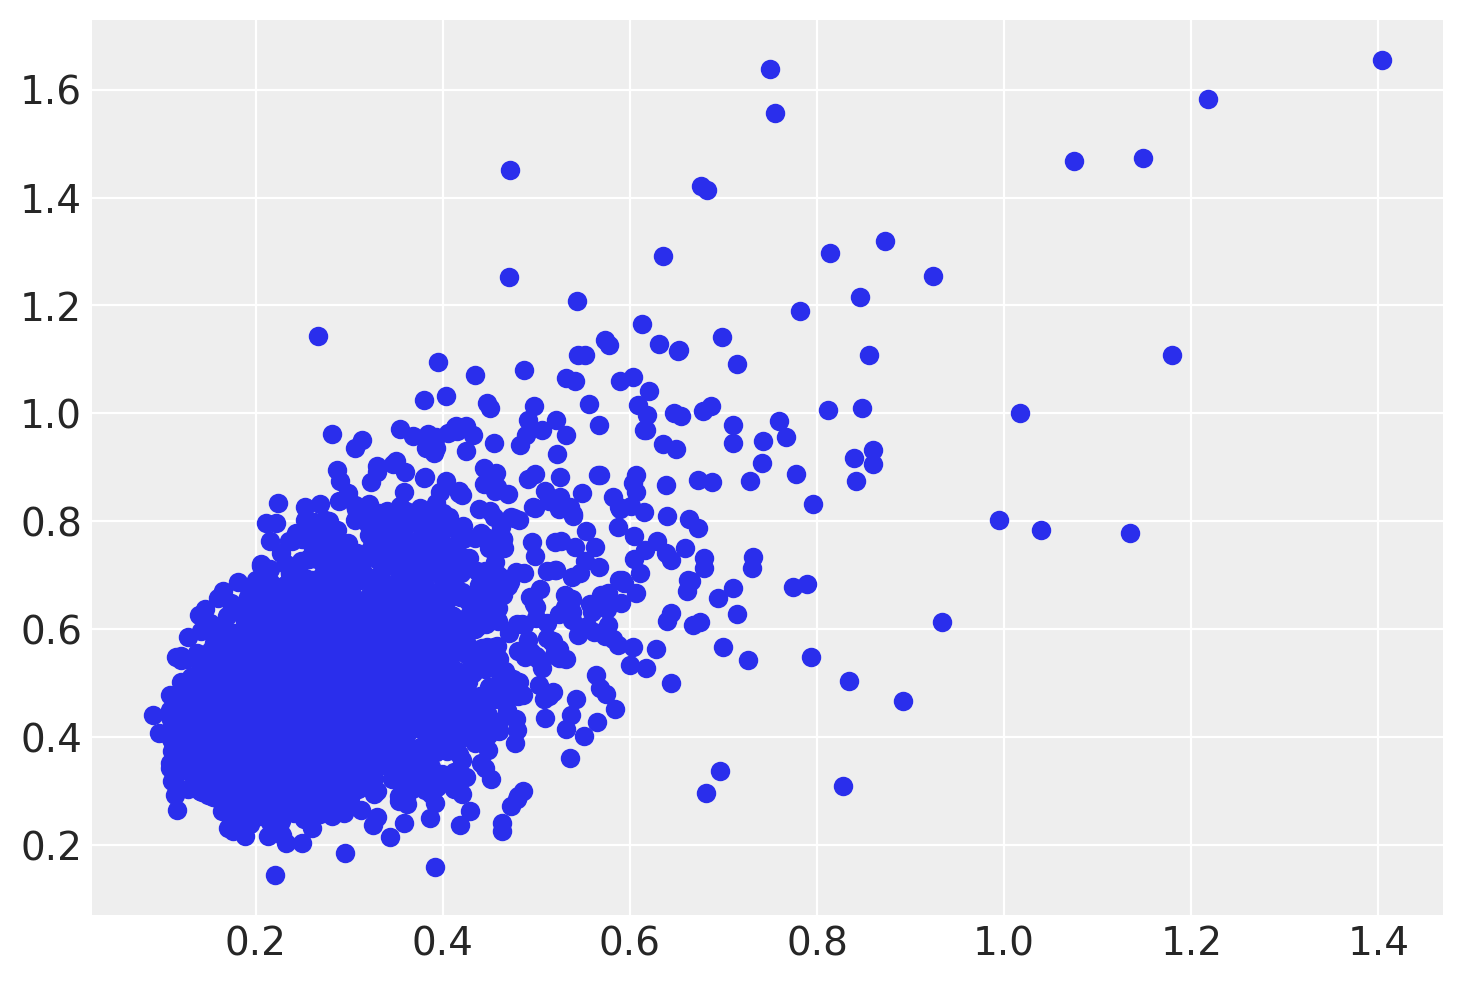

<IPython.core.display.Javascript object>

In [259]:
plt.scatter(np.exp(df_sample[("posterior", "log_sigma")]), sigmas)

<AxesSubplot:>

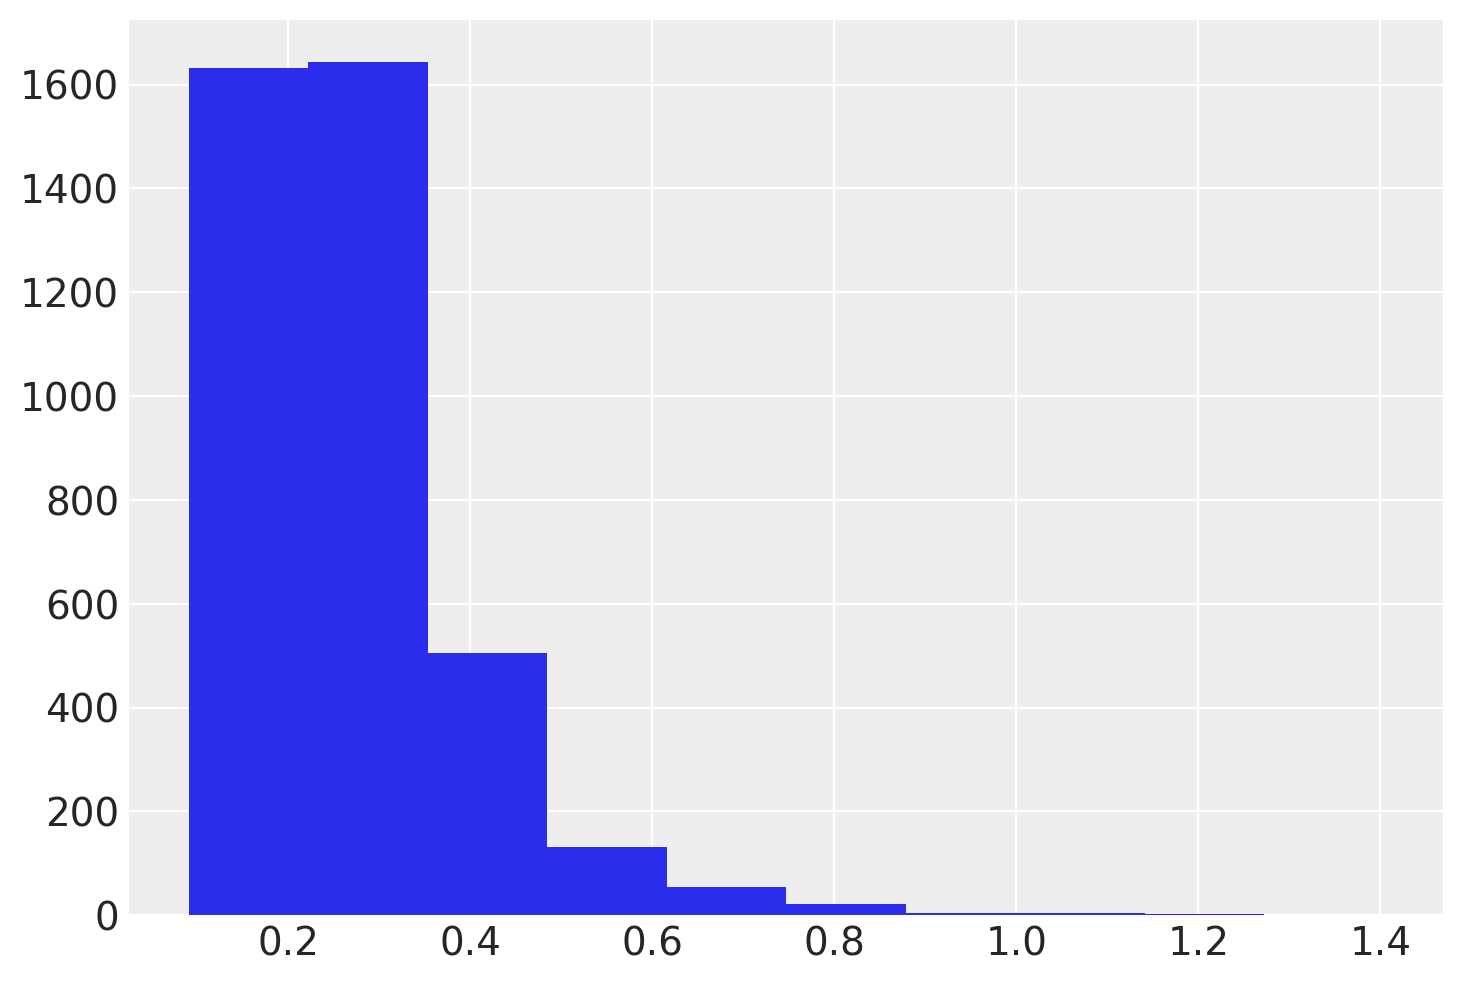

<IPython.core.display.Javascript object>

In [262]:
np.exp(df_sample[("posterior", "log_sigma")]).hist()

<AxesSubplot:>

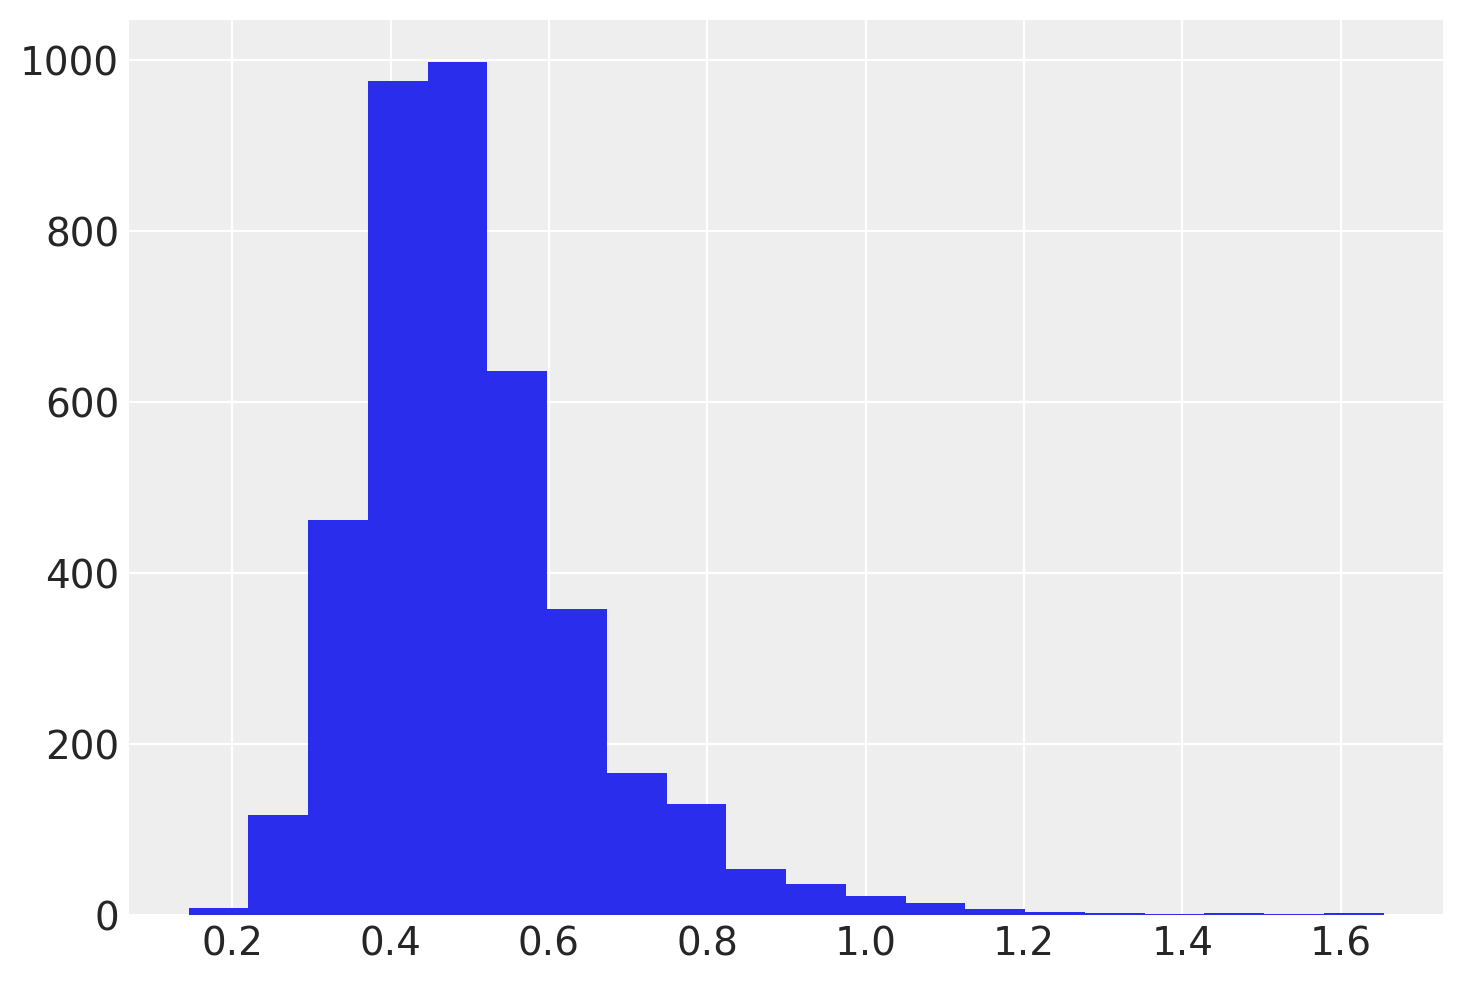

<IPython.core.display.Javascript object>

In [295]:
sigmas.hist(bins=20)

In [250]:
df_brains["brain_std"]

0    0.324444
1    0.334815
2    0.453333
3    0.385926
4    0.557037
5    0.645185
6    1.000000
Name: brain_std, dtype: float64

<IPython.core.display.Javascript object>

## Closest I could get

In [38]:
lppd_vals = list()
for i in range(7):
    posterior_a = df_sample[("posterior", "a")]
    posterior_b = df_sample[("posterior", "b")]
    posterior_sigma = np.exp(df_sample[("posterior", "log_sigma")])
    # posterior_sigma = df_sample[("posterior", "log_sigma")]

    brain_std_i = df_brains["brain_std"][i].copy()
    mass_std_i = df_brains["mass_std"][i].copy()

    logprob = stats.norm.logpdf(
        brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=posterior_sigma
    )

    prob = stats.norm.pdf(
        brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=posterior_sigma
    )

    # print(prob.mean())
    # print(np.log(prob.mean()))
    print(logsumexp(logprob - np.log(len(logprob))))
    lppd_vals.append(logsumexp(logprob - np.log(len(logprob))))

0.37270165846943026
0.396449915671079
0.3106210239291123
0.3877791607490835
0.25295410543064456
0.2061491471455028
-0.5928167458268048


<IPython.core.display.Javascript object>

In [304]:
len(logprob)

4000

<IPython.core.display.Javascript object>

In [311]:
# numpyro sigmas
lppd_vals = list()
for i in range(7):
    posterior_a = df_sample[("posterior", "a")]
    posterior_b = df_sample[("posterior", "b")]
    posterior_sigma = np.exp(df_sample[("posterior", "log_sigma")])
    # posterior_sigma = df_sample[("posterior", "log_sigma")]

    brain_std_i = df_brains["brain_std"][i].copy()
    mass_std_i = df_brains["mass_std"][i].copy()

    logprob = stats.norm.logpdf(
        brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=numpyro_sigmas
    )

    prob = stats.norm.pdf(
        brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=numpyro_sigmas
    )

    # print(prob.mean())
    # print(np.log(prob.mean()))
    print(logsumexp(logprob - np.log(len(logprob))))
    lppd_vals.append(logsumexp(logprob - np.log(len(logprob))))

0.52183294
0.5421438
0.43931007
0.55461884
0.37164688
0.30179596
-0.6532345


<IPython.core.display.Javascript object>

In [264]:

lppd_vals = list()
for i in range(7):
    posterior_a = df_sample[("posterior", "a")]
    posterior_b = df_sample[("posterior", "b")]
    posterior_sigma = np.exp(df_sample[("posterior", "log_sigma")])
    # posterior_sigma = df_sample[("posterior", "log_sigma")]

    brain_std_i = df_brains["brain_std"][i].copy()
    mass_std_i = df_brains["mass_std"][i].copy()

    logprob = stats.norm.logpdf(
        brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=sigmas
    )

    prob = stats.norm.pdf(
        brain_std_i, loc=posterior_a + posterior_b * mass_std_i, scale=sigmas
    )

    # print(prob.mean())
    # print(np.log(prob.mean()))
    print(logsumexp(logprob - np.log(len(logprob))))
    lppd_vals.append(logsumexp(logprob - np.log(len(logprob))))

-0.2013541776879464
-0.20315788065942453
-0.24545748325092376
-0.19031039296525964
-0.22779293792325994
-0.25606872052888363
-0.5364279126218916


<IPython.core.display.Javascript object>

In [235]:
sum(lppd_vals) * 2

2.652993562139571

<IPython.core.display.Javascript object>

In [266]:
actual_vals = [
    0.6098668,
    0.6483438,
    0.5496093,
    0.6234934,
    0.4648143,
    0.4347605,
    -0.8444633,
]

<IPython.core.display.Javascript object>

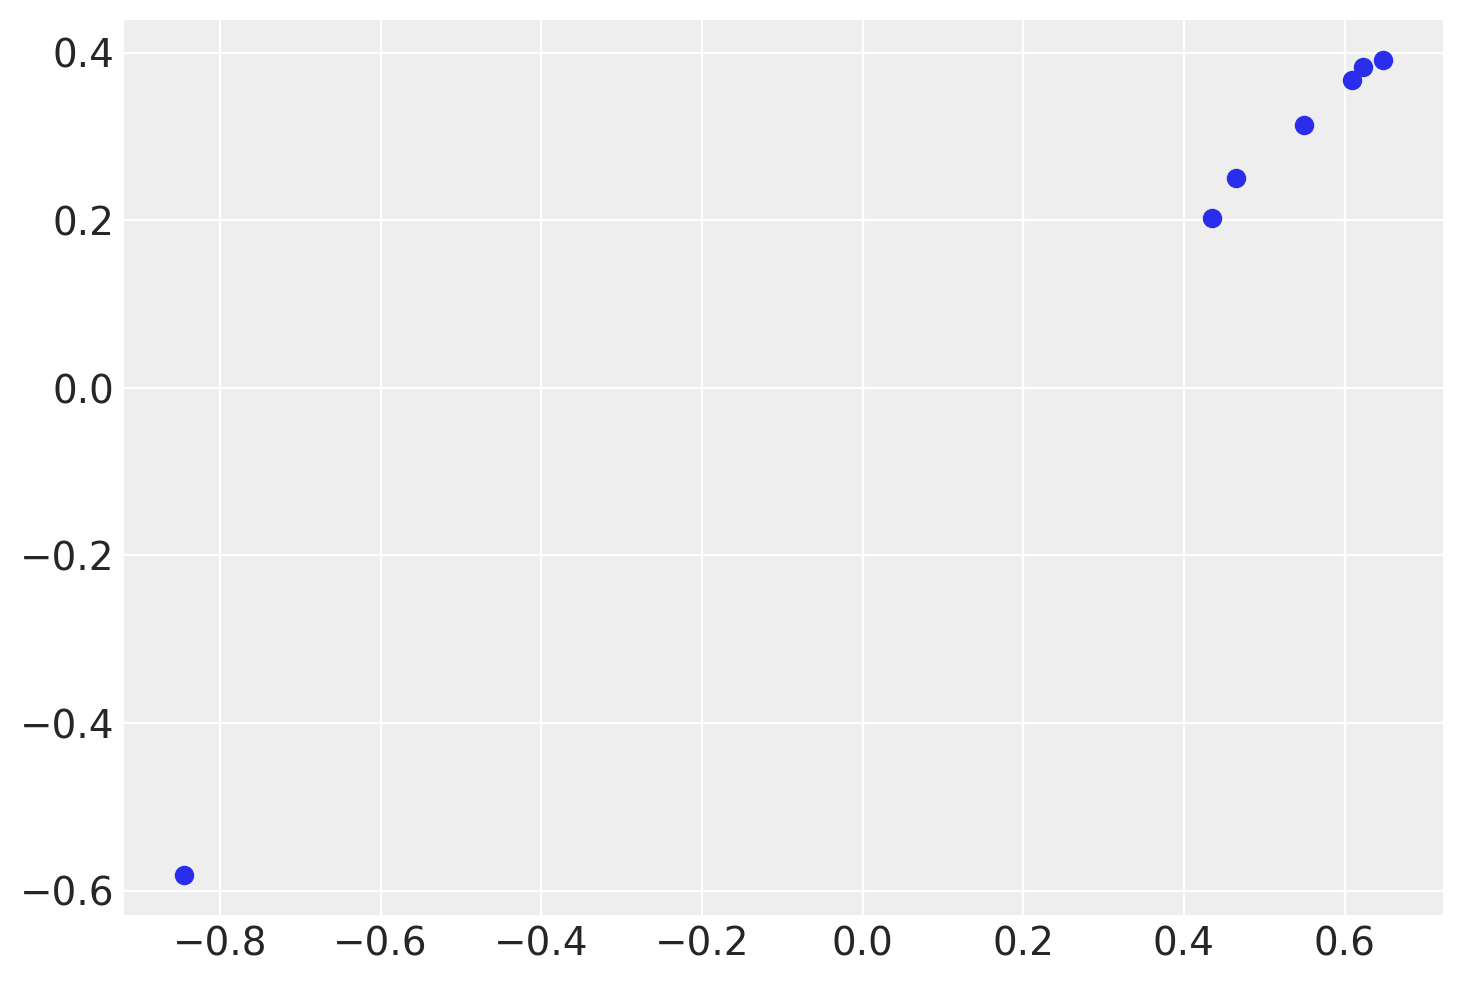

<IPython.core.display.Javascript object>

In [267]:
plt.scatter(actual_vals, lppd_vals)

In [166]:
prob.max()

1.5547397458253098

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

```
a = np.arange(10)

b = np.arange(10, 0, -1)

logsumexp(a, b=b)
#9.9170178533034665

np.log(np.sum(b*np.exp(a)))
#9.9170178533034647
```

In [158]:
logsumexp(logprob) - np.log(len(logprob))

-0.4936129070982638

<IPython.core.display.Javascript object>

In [160]:
np.mean(logprob)

-0.6362357667238104

<IPython.core.display.Javascript object>

In [ ]:
for i in range(7):
    print(np.mean(return_logprob(df_sample, df_brains["mass_std"]).iloc[i, :]))

(array([7.000e+00, 2.100e+01, 1.530e+02, 1.068e+03, 2.140e+03, 5.260e+02,
        7.200e+01, 7.000e+00, 5.000e+00, 1.000e+00]),
 array([-1.52986527, -1.15533968, -0.7808141 , -0.40628852, -0.03176294,
         0.34276265,  0.71728823,  1.09181381,  1.46633939,  1.84086498,
         2.21539056]),
 <BarContainer object of 10 artists>)

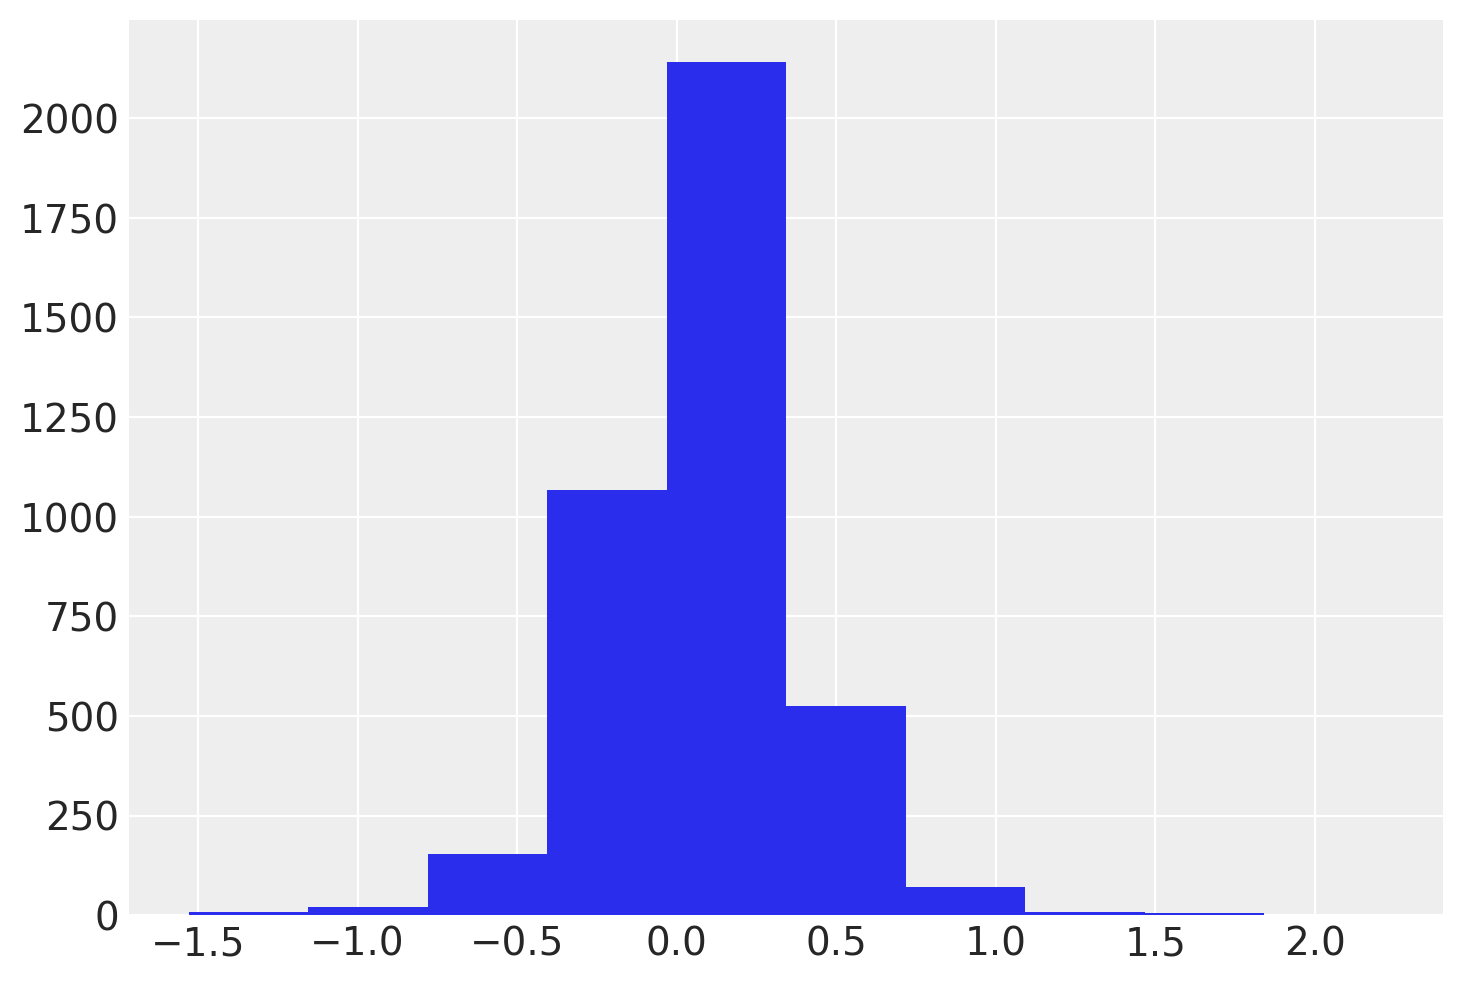

<IPython.core.display.Javascript object>

In [238]:
plt.hist(return_logprob(df_sample, df_brains["mass_std"]).iloc[0, :])

0.07982586445382135
0.005925932111824684
-0.05029383184569467
0.3225735844536676
1.0665934385500737
1.3529622903137162
0.9606894184038254


<IPython.core.display.Javascript object>

In [41]:
len(df_sample)

4000

<IPython.core.display.Javascript object>

In [43]:
df_brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


<IPython.core.display.Javascript object>

# Calculation of log-score

At this point, I was still confused about where log-score comes in. Looking at the repo didn't help me. I looked again at the definition of log score.

$S(q) = \displaystyle\sum\limits_{i} \text{log}(q_i)$

In plan words, it is taking the sum of the log probabilities of *each observation*. Where does the probability come in? I remembered a prior post.

Let's look at the probability distributions and observed values for two species, havilis and africanus.

In [104]:
mu_for_habilis = (
    df_sample[("posterior", "a")]
    + df_sample[("posterior", "b")] * df_brains.loc[2, "mass_std"]
)

mu_for_africanus = (
    df_sample[("posterior", "a")]
    + df_sample[("posterior", "b")] * df_brains.loc[1, "mass_std"]
)

<IPython.core.display.Javascript object>

Each observed value has an associated probability based on what the model predicts.

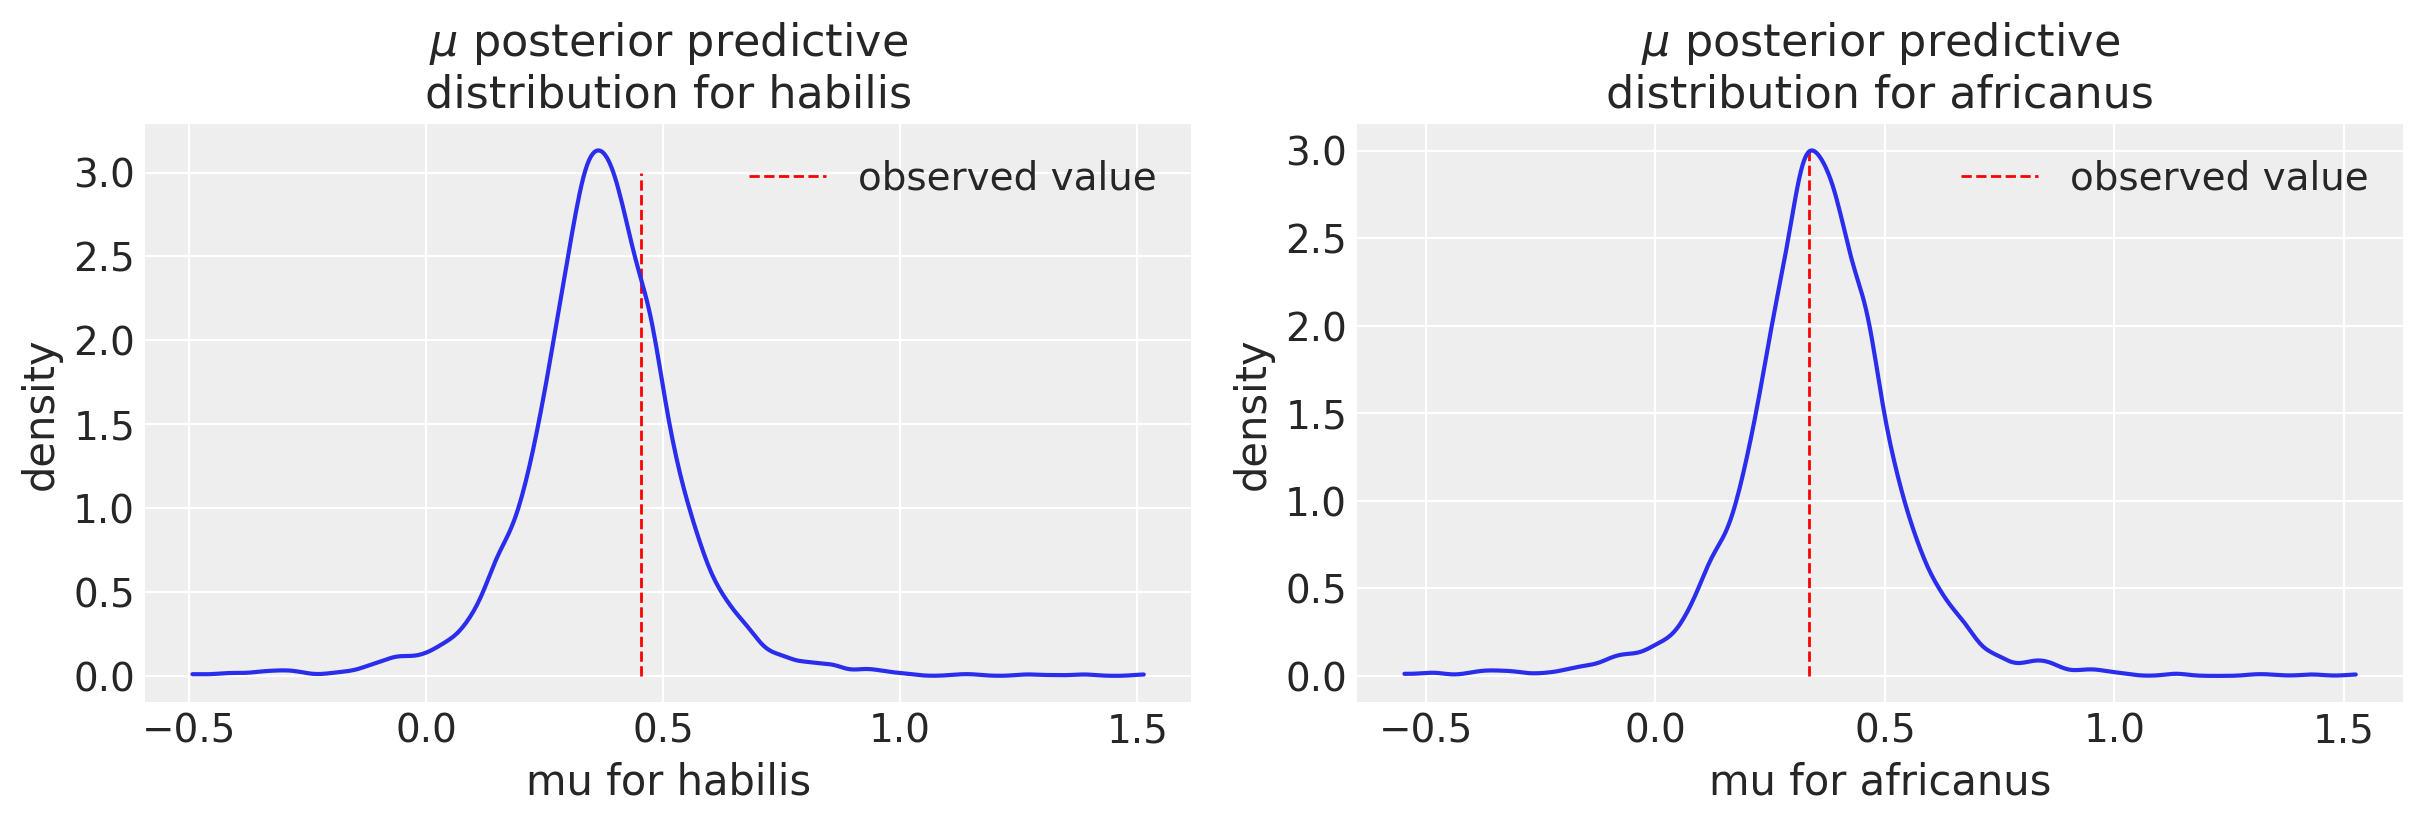

<IPython.core.display.Javascript object>

In [107]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

az.plot_kde(mu_for_africanus, ax=ax1)
ax1.set_title("$\mu$ posterior predictive\ndistribution for habilis")
ax1.set_ylabel("density")
ax1.set_xlabel("mu for habilis")
ax1.vlines(
    df_brains.loc[2, "brain_std"],
    ymin=0,
    ymax=3,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="observed value",
)
ax1.legend()


az.plot_kde(mu_for_habilis, ax=ax2)
ax2.set_title("$\mu$ posterior predictive\ndistribution for africanus")
ax2.set_ylabel("density")
ax2.set_xlabel("mu for africanus")
ax2.vlines(
    df_brains.loc[1, "brain_std"],
    ymin=0,
    ymax=3,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="observed value",
)
ax2.legend()

The posterior predictive distribution makes it clear that africanus is closer to its mean prediction with this model than habilis. We can see this in the scatter plot above as well but showing it this way brings us closer to how we can use it in the log score.

In [115]:
df_brains.head()

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037


<IPython.core.display.Javascript object>

<ipython-input-124-2a31d772d2af>:39: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


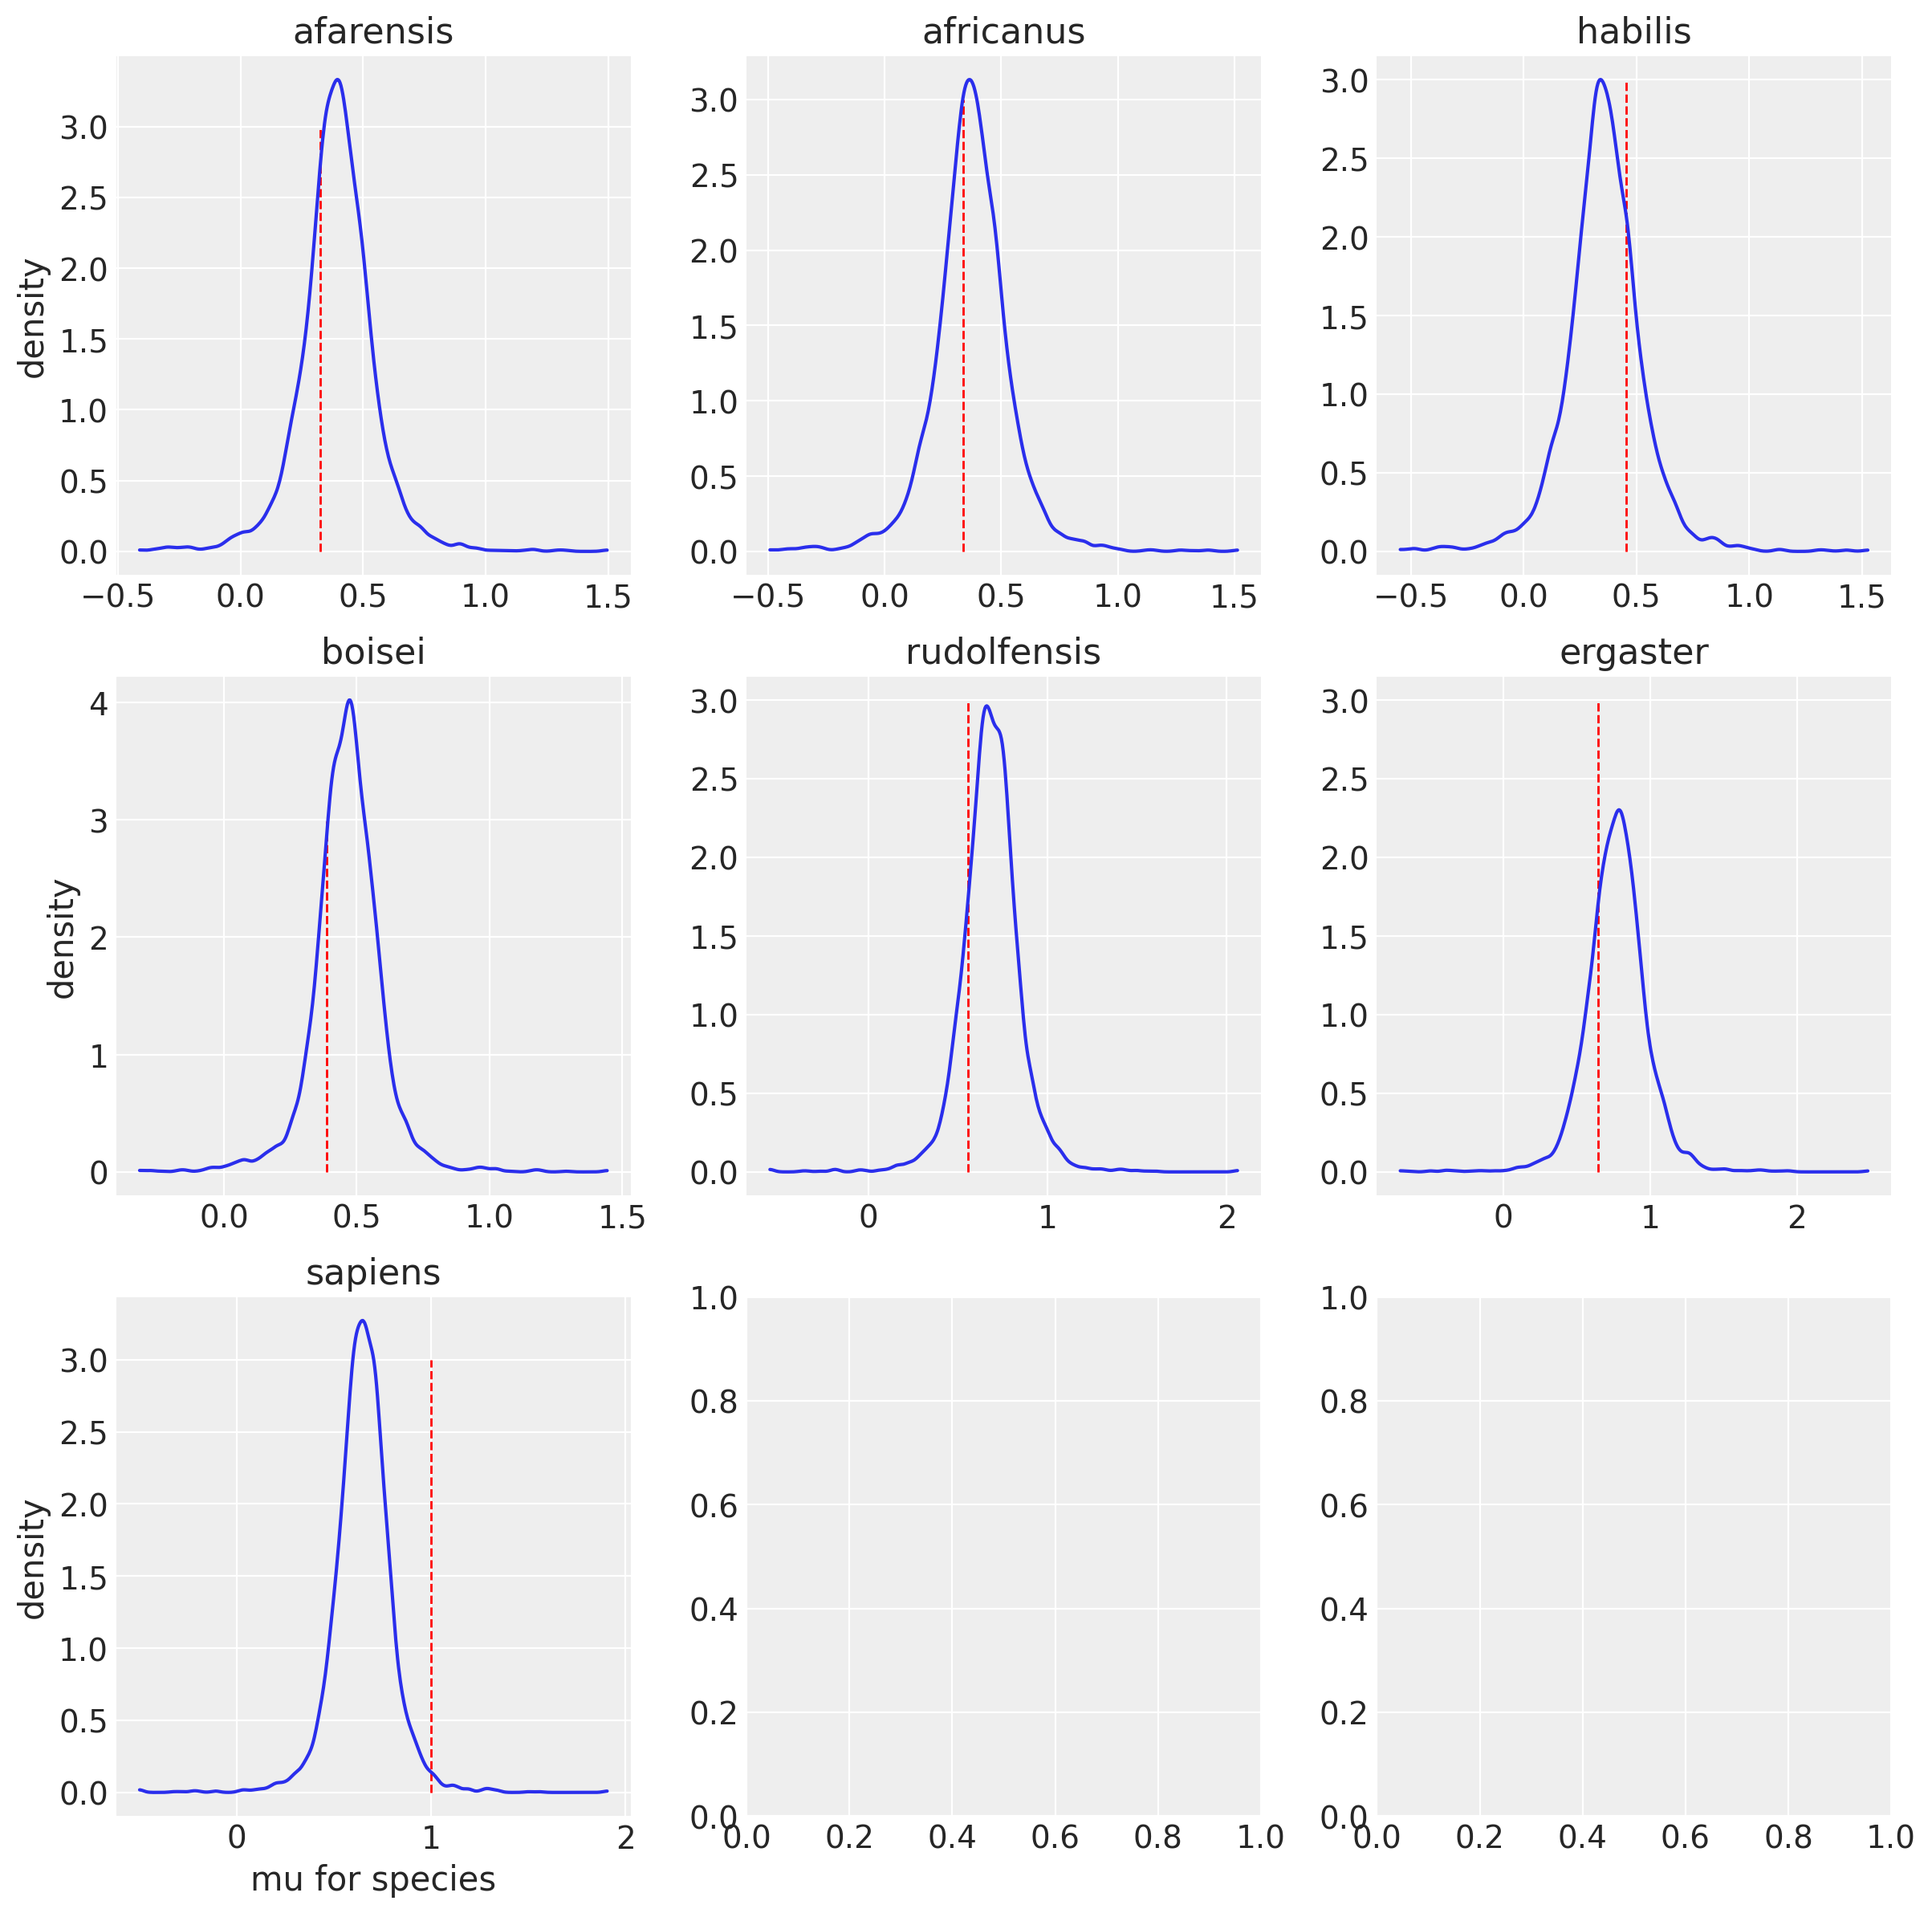

<IPython.core.display.Javascript object>

In [124]:
f, axes = plt.subplots(3, 3, figsize=(12, 12))


for i, species, ax in zip(df_brains.index, df_brains['species'], axes.flat):
    mu_for_species = (
    df_sample[("posterior", "a")]
    + df_sample[("posterior", "b")] * df_brains.loc[i, "mass_std"]
)
    
    az.plot_kde(mu_for_species, ax=ax)
    ax.set_title(species)
#     ax1.set_title("$\mu$ posterior predictive\ndistribution for habilis")
#     ax1.set_ylabel("density")
#     ax1.set_xlabel("mu for habilis")
    ax.vlines(
        df_brains.loc[i, "brain_std"],
        ymin=0,
        ymax=3,
        color="red",
        linestyle="dashed",
        linewidth=1,
        label='observed'
    )

    if ax.is_first_col():
        ax.set_ylabel("density")

    if ax.is_last_row():
        ax.set_xlabel("mu for species")

#     if ax.is_last_row():
#         ax.set_ylim(-500, 2100)
#         ax.axhline(0, ls="dashed", c="k", lw=1)
#         ax.set_yticks([0, 450, 1300])
#     else:
#         ax.set_ylim(300, 1600)
#         ax.set_yticks([450, 900, 1300])

f.tight_layout()

# az.plot_kde(mu_for_africanus, ax=ax1)
# ax1.set_title("$\mu$ posterior predictive\ndistribution for habilis")
# ax1.set_ylabel("density")
# ax1.set_xlabel("mu for habilis")
# ax1.vlines(
#     df_brains.loc[2, "brain_std"],
#     ymin=0,
#     ymax=3,
#     color="red",
#     linestyle="dashed",
#     linewidth=1,
#     label="observed value",
# )
# ax1.legend()


In [110]:
df_brains.loc[2, "brain_std"]

0.4533333333333333

<IPython.core.display.Javascript object>

In [114]:
((mu_for_habilis > 0.453) & (mu_for_habilis < 0.454)).sum()

8

<IPython.core.display.Javascript object>

# Numpyro version


Following [this](https://fehiepsi.github.io/rethinking-numpyro/07-ulysses-compass.html).

In [26]:
!pip install numpyro jax==0.2.10

Processing /Users/blacar/Library/Caches/pip/wheels/42/76/93/4efdcc626990c35448e8163b3e988184f77a061ad0437f922d/jax-0.2.10-py3-none-any.whl
  Attempting uninstall: jax
    Found existing installation: jax 0.2.13
    Uninstalling jax-0.2.13:
      Successfully uninstalled jax-0.2.13


<IPython.core.display.Javascript object>

In [27]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, ops, random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation


AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

<IPython.core.display.Javascript object>

In [30]:
import jax.numpy as jnp

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

<IPython.core.display.Javascript object>

In [28]:
if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

In [29]:
sppnames = [
    "afarensis",
    "africanus",
    "habilis",
    "boisei",
    "rudolfensis",
    "ergaster",
    "sapiens",
]
brainvolcc = jnp.array([438, 452, 612, 521, 752, 871, 1350])
masskg = jnp.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

NameError: name 'jnp' is not defined

<IPython.core.display.Javascript object>

In [25]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

<IPython.core.display.Javascript object>

In [26]:
d

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


<IPython.core.display.Javascript object>

In [27]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b * mass_std)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1,
    optim.Adam(0.3),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
p7_1, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1334.35it/s, init loss: 115.9437, avg. loss [951-1000]: 3.6486]


<IPython.core.display.Javascript object>

In [28]:
post = m7_1.sample_posterior(random.PRNGKey(12), p7_1, (4000,))
s = Predictive(m7_1.model, post)(random.PRNGKey(2), d.mass_std.values)
r = jnp.mean(s["brain_std"], 0) - d.brain_std.values
resid_var = jnp.var(r, ddof=1)

<IPython.core.display.Javascript object>

### Numpyro sigma

(array([ 26., 133., 306., 495., 578., 589., 546., 438., 292., 211., 144.,
         85.,  62.,  40.,  23.,  15.,   6.,   4.,   4.,   3.]),
 array([0.06848495, 0.08812191, 0.10775886, 0.12739582, 0.14703278,
        0.16666974, 0.1863067 , 0.20594366, 0.22558062, 0.24521758,
        0.26485455, 0.2844915 , 0.30412847, 0.32376543, 0.3434024 ,
        0.36303934, 0.3826763 , 0.40231326, 0.42195022, 0.44158718,
        0.46122414], dtype=float32),
 <BarContainer object of 20 artists>)

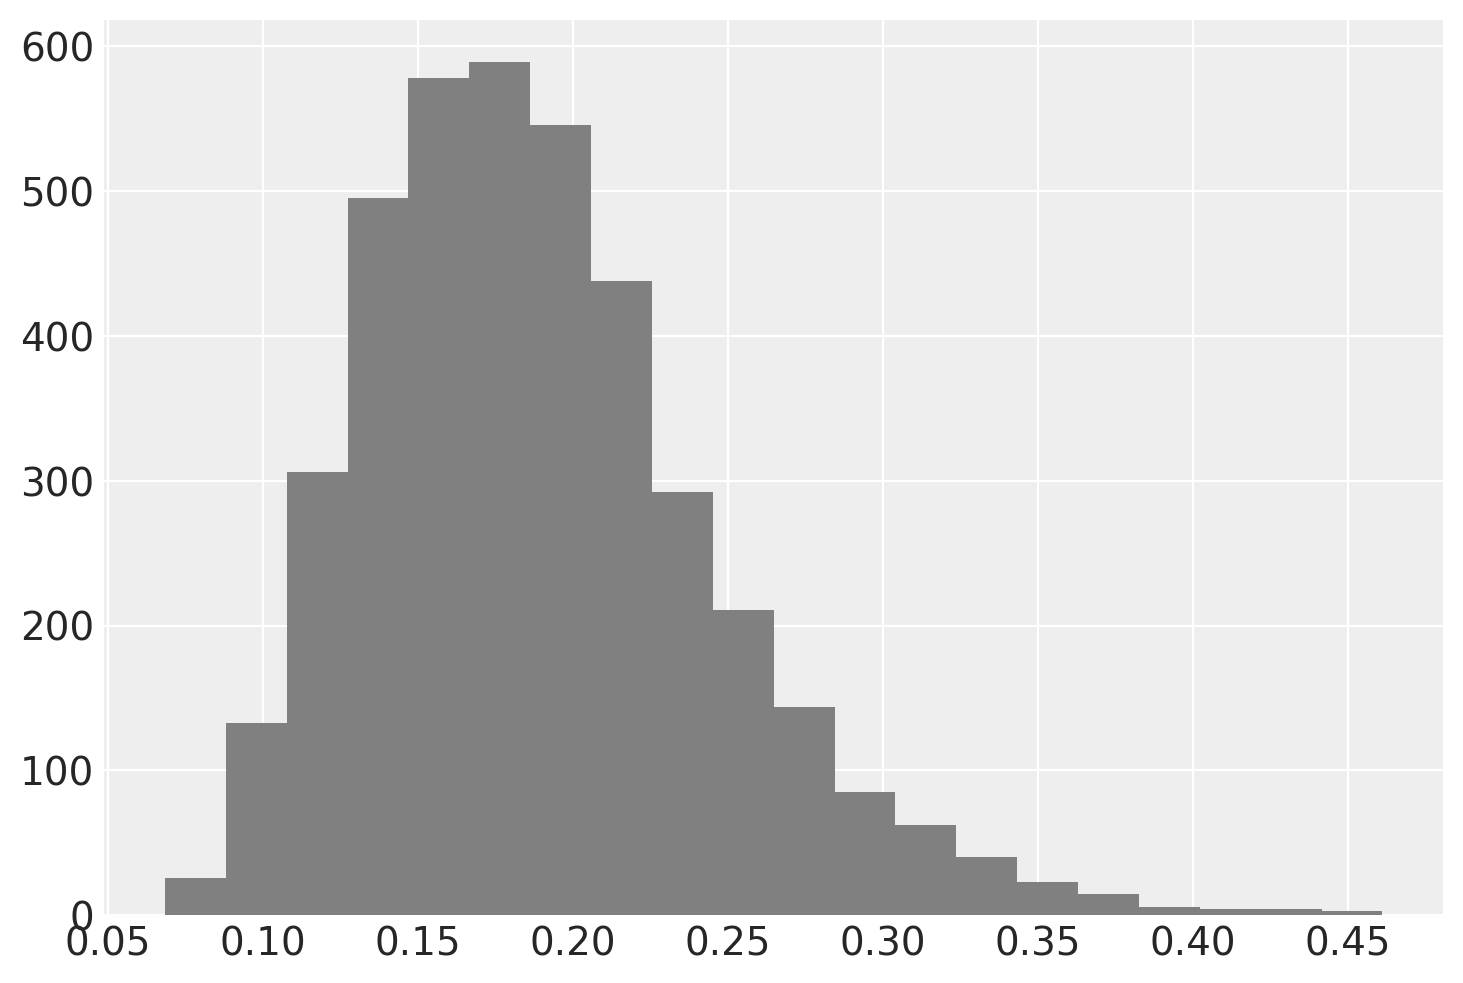

<IPython.core.display.Javascript object>

In [29]:
plt.hist(np.exp(post["log_sigma"]), bins=20, color="gray")

In [30]:
numpyro_sigmas = np.exp(post["log_sigma"])

<IPython.core.display.Javascript object>

In [31]:
len(numpyro_sigmas)

4000

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [12]:
%watermark -n -u -v -iv -w

Last updated: Thu Feb 18 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.1
matplotlib: 3.3.4
arviz     : 0.11.1
pandas    : 1.2.1
seaborn   : 0.11.1
json      : 2.0.9
pymc3     : 3.11.0
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [13]:
# Custom scripts to show packages and versions in this notebook
def imports():
    import types

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__


imported_packages = list(imports())

from active_pkg import show_pkg_vers_in_nb

show_pkg_vers_in_nb(imported_packages)

# Name                    Version                   Build  Channel
arviz                     0.11.1                   pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.20.1                   pypi_0    pypi
pandas                    1.2.1                    pypi_0    pypi
pymc3                     3.11.0                   pypi_0    pypi
scipy                     1.6.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi


<IPython.core.display.Javascript object>